# Superstore Marketing Campaign Dataset

## Business Context 

The marketing team wanted to promote a discounted Gold Membership — offering a 20% discount on all purchases for \\$499 instead of the normal pricing of \\$999. To minimize campaign costs, leadership requested a predictive model to classify which existing customers were most likely to purchase the offer.

**Objectives:**
* Predict the likelihood of a customer purchasing the Gold Membership
* Identify key features that drive positive purchase responses
* Generate a prioritized call list of high-potential customers for the outbound campaign

Kaggle Project: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset

## Analytical Approach
---
1. Exploratory Analysis
2. Data Cleaning
3. Feature Prep
4. Data Splitting
5. Create Baseline Model
6. Optimize Model & Final Model Summary
7. Export Data for Calling Campaign
8. Executive Report

## Section 1: Exploratory Analysis

---

**Section Objectives:**
*   Inspect dataset structure and target balance
*   Identify data quality issues (missing values, inconsistent categories)
*   Flag potential leakage risks due to aggregated or rolled-up behavioral fields
*   Determine which features may require consolidation or preprocessing before modeling

In [1]:
import pandas as pd

# Import data from github repository
url = "https://raw.githubusercontent.com/Analyst-KatieD/kaggle-superstore-marketing/main/superstore_data.csv"
df = pd.read_csv(url)

# Display the first few rows to confirm it loaded correctly
df.head()


,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1501,1982,PhD,Married,160803.0,0,0,2012-04-08,21,55,...,17,3,4,15,0,28,1,0,0,0
1,8475,1973,PhD,Married,157243.0,0,1,2014-01-03,98,20,...,1,2,1,15,0,22,0,0,0,0
2,8720,1978,2n Cycle,Together,NaN,0,0,2012-12-08,53,32,...,12,4,22,0,0,0,1,0,0,0
3,5555,1975,Graduation,Divorced,153924.0,0,0,2014-07-02,81,1,...,1,1,1,0,0,0,0,0,0,0
4,11181,1949,PhD,Married,156924.0,0,0,2013-08-29,85,2,...,1,1,1,0,0,0,0,0,0,0


In [2]:
import numpy as np #more numeric formulas
import matplotlib.pyplot as plt #for nice histograms
import seaborn as sns #for boxplots and heat map
from statsmodels.formula.api import logit #to build the regression model
import scipy.stats as stats #to calculate z-score
import missingno as msno #to visualize missing values
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm #for residual plots
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
# Convert the object column to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d')

# Check the result
print(df['Dt_Customer'].dtype)
df['Dt_Customer'].head()

datetime64[ns]


0   2012-04-08
1   2014-01-03
2   2012-12-08
3   2014-07-02
4   2013-08-29
Name: Dt_Customer, dtype: datetime64[ns]

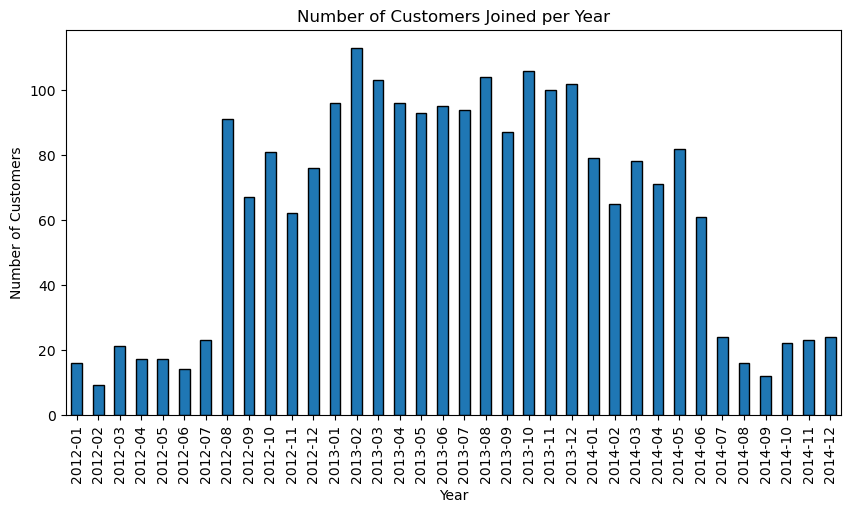

In [5]:
# Format: YYYY-MM
df['Join_YearMonth'] = df['Dt_Customer'].dt.to_period('M')

# Count customers per year-month
join_counts = df['Join_YearMonth'].value_counts().sort_index()

plt.figure(figsize=(10,5))
join_counts.plot(kind='bar', edgecolor='k')
plt.title('Number of Customers Joined per Year')
plt.xlabel('Year')
plt.ylabel('Number of Customers')
plt.show()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

**Field Types Summary**
- Categorical: Education, Marital_Status, Kidhome, Teenhome, Complain  
- Numeric: Spend fields, purchase counts, Recency, Income  
- Date/Period: Dt_Customer, Join_YearMonth  
- Target: Response  

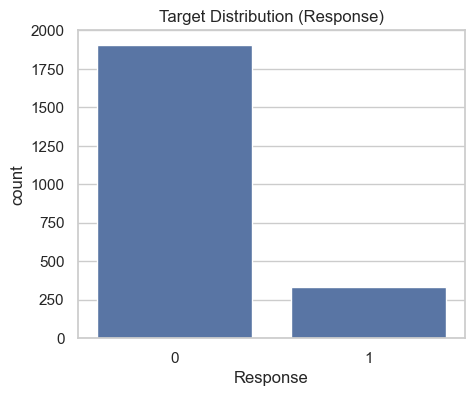

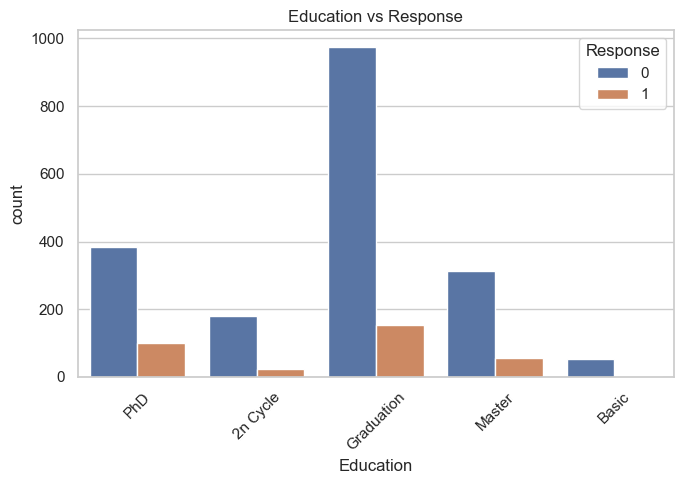

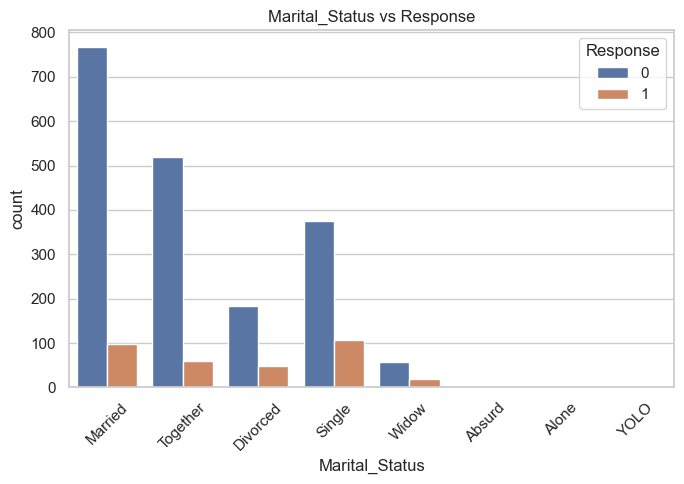

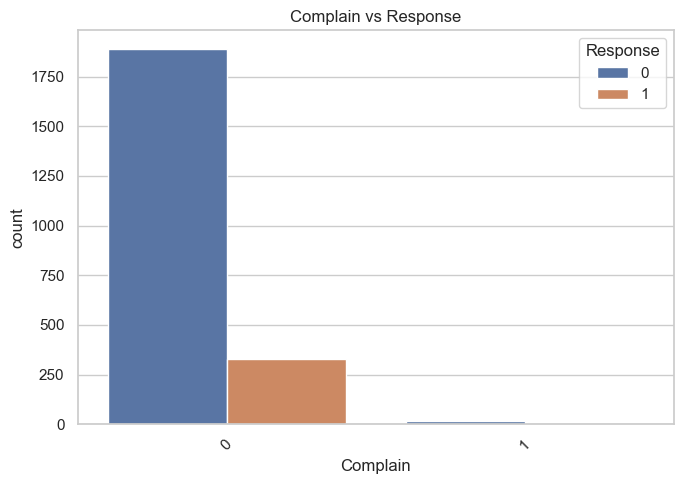

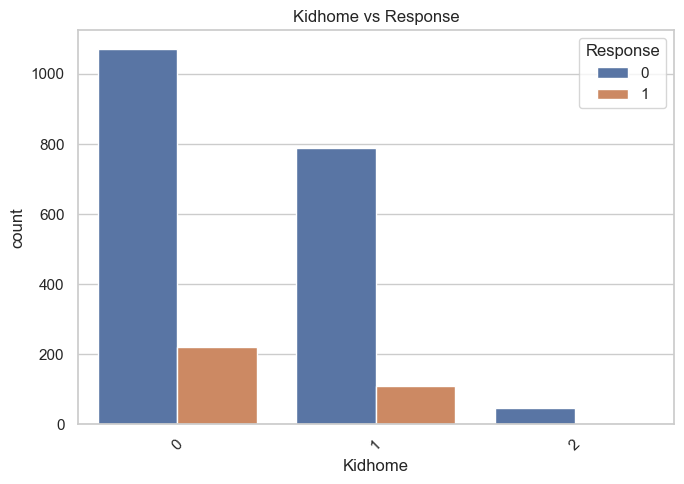

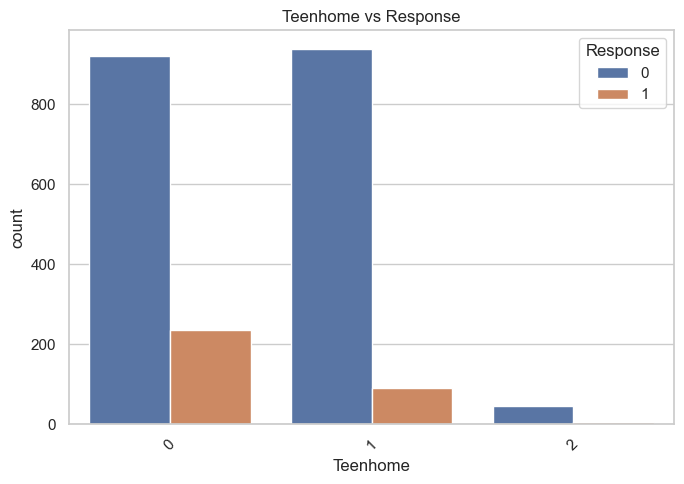

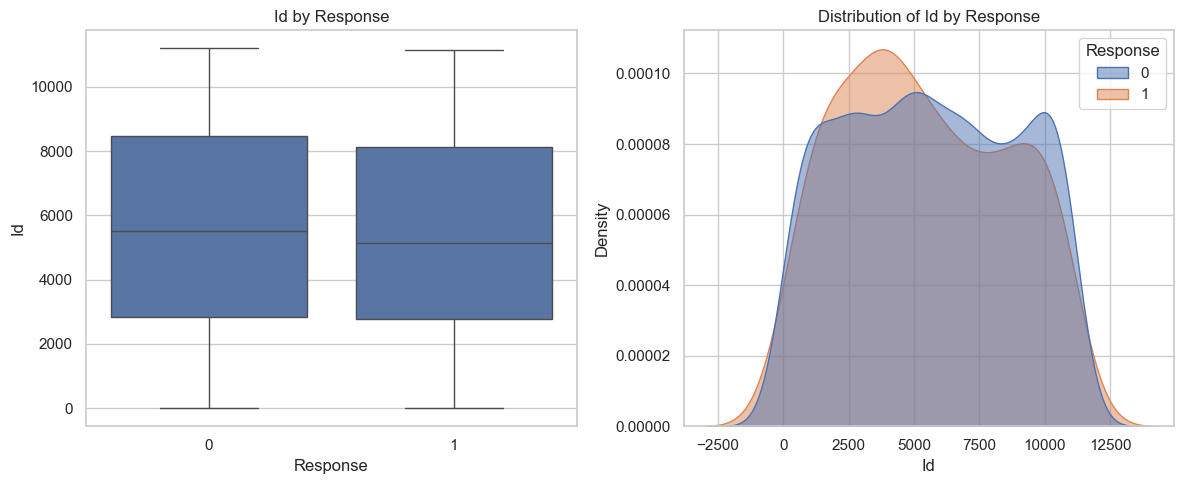

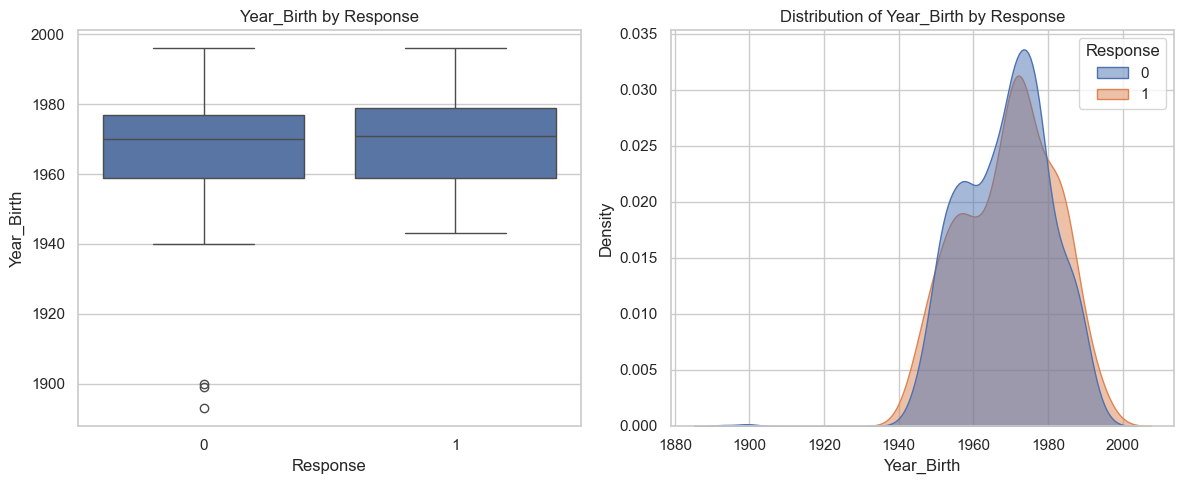

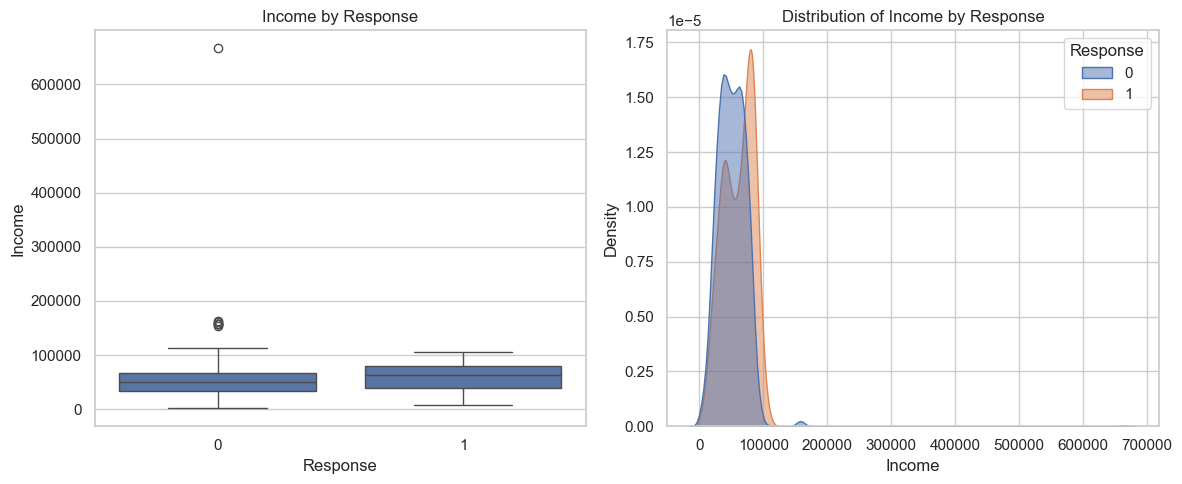

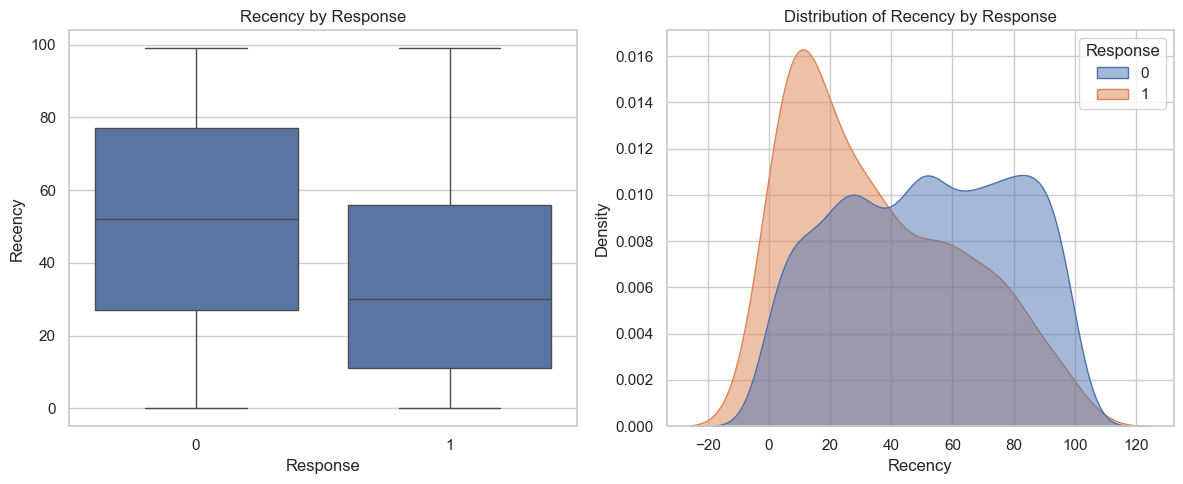

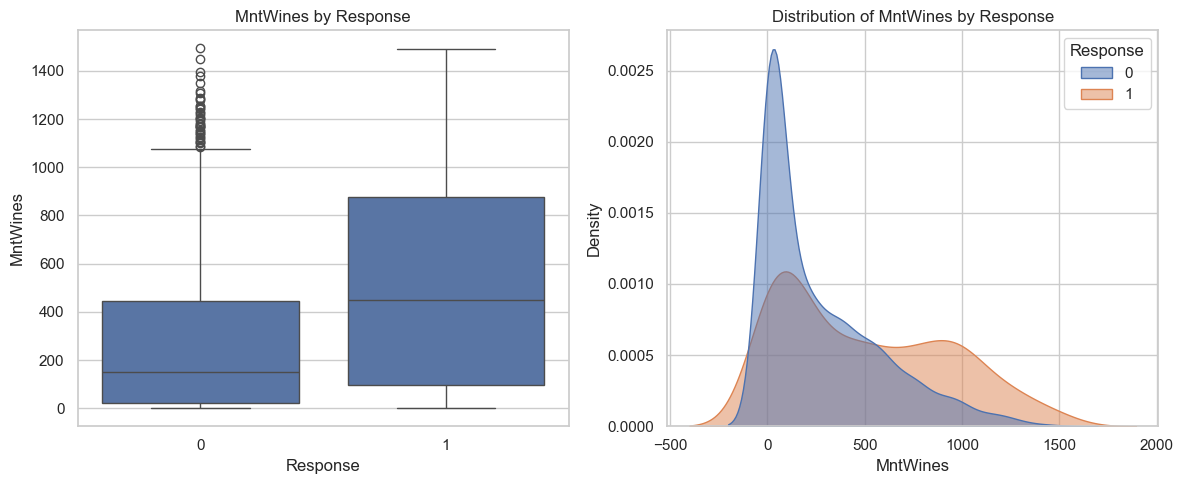

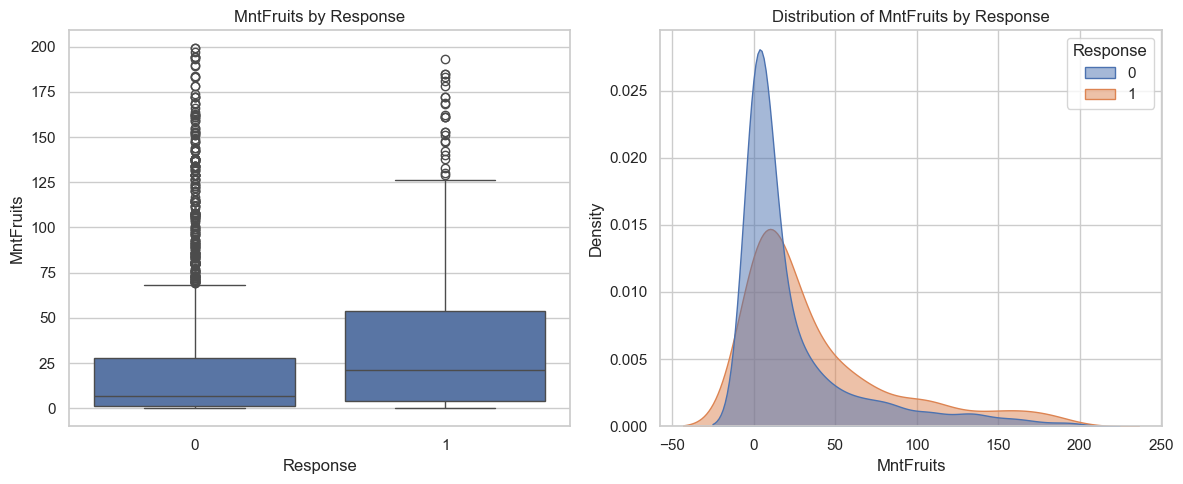

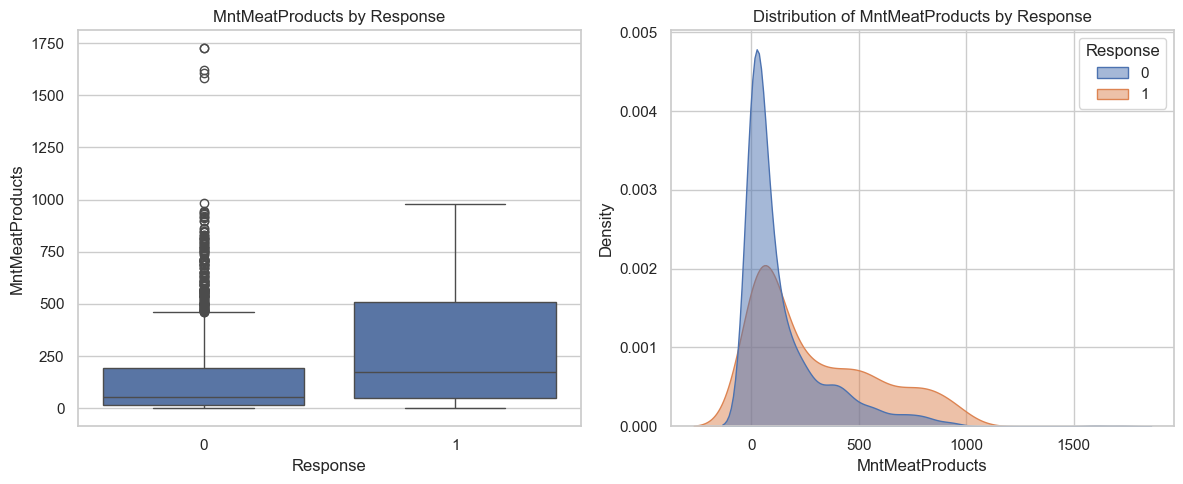

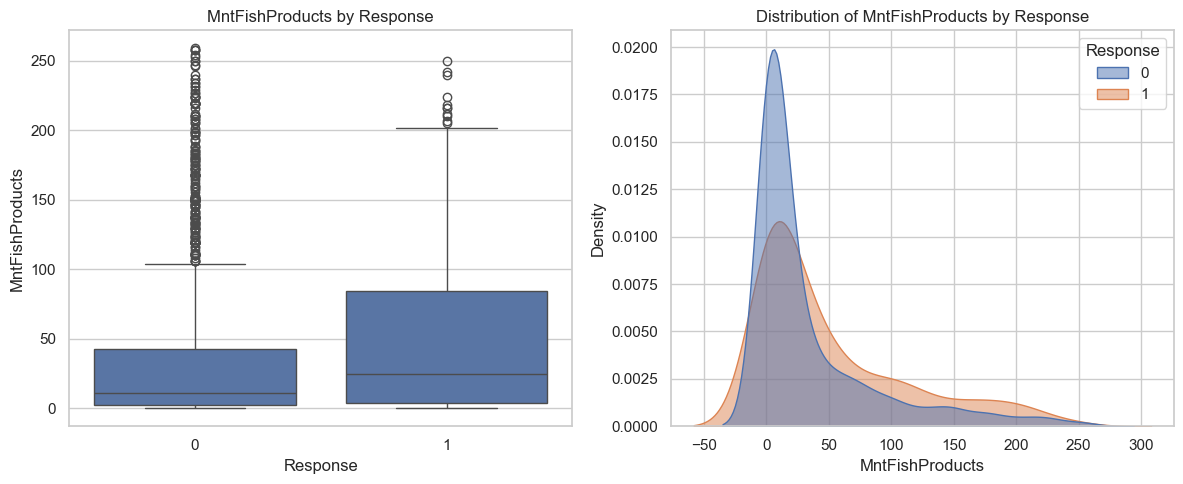

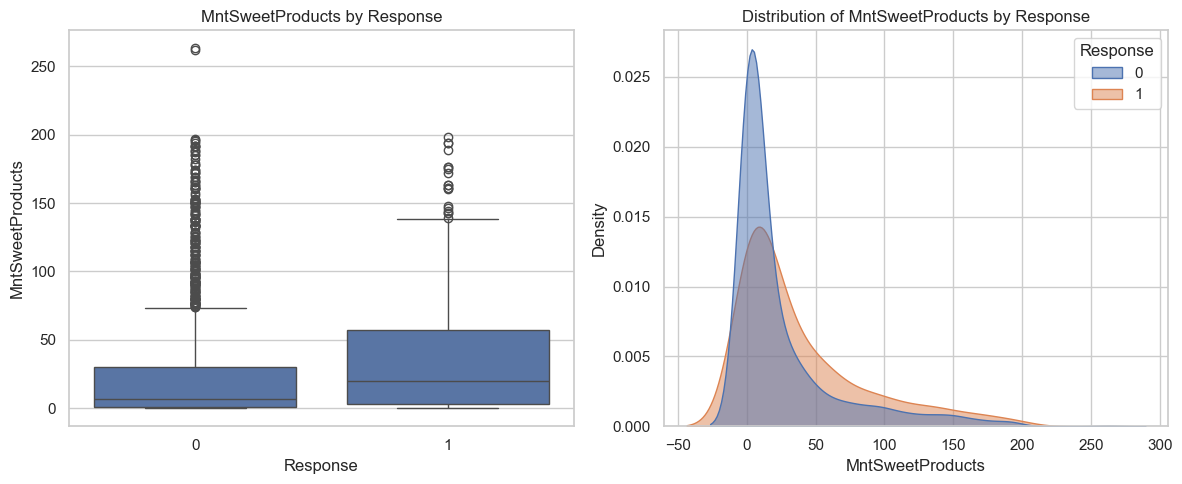

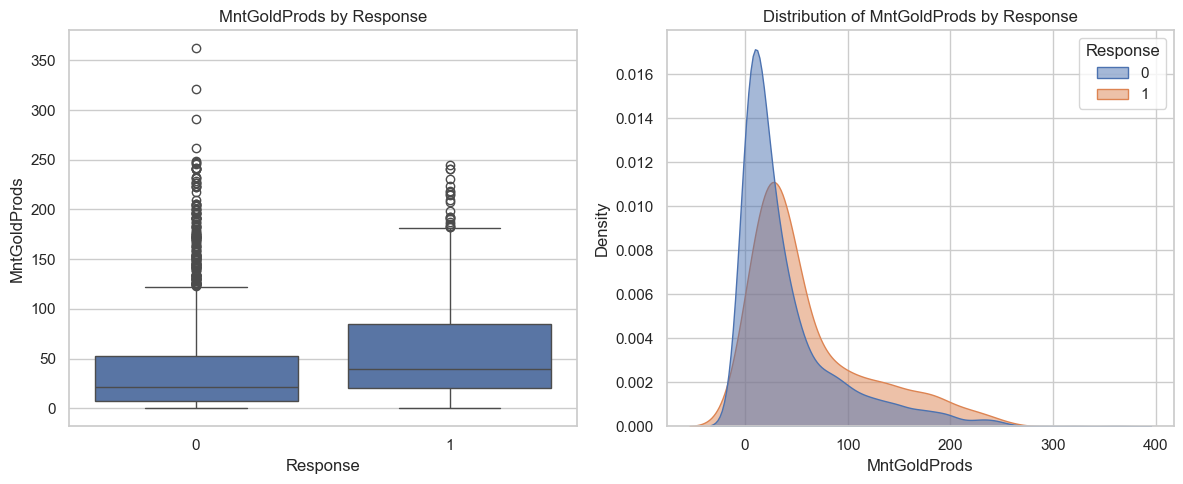

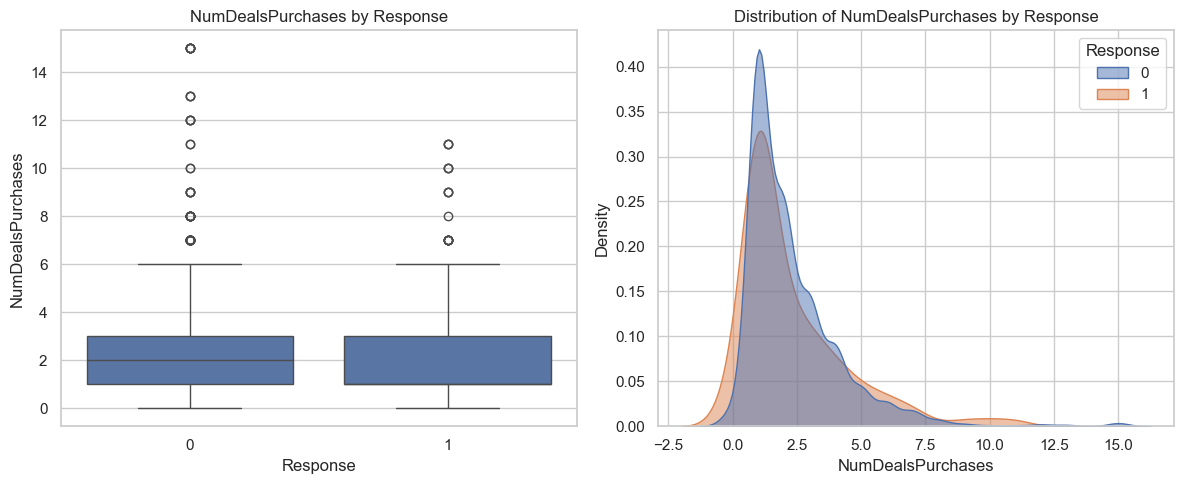

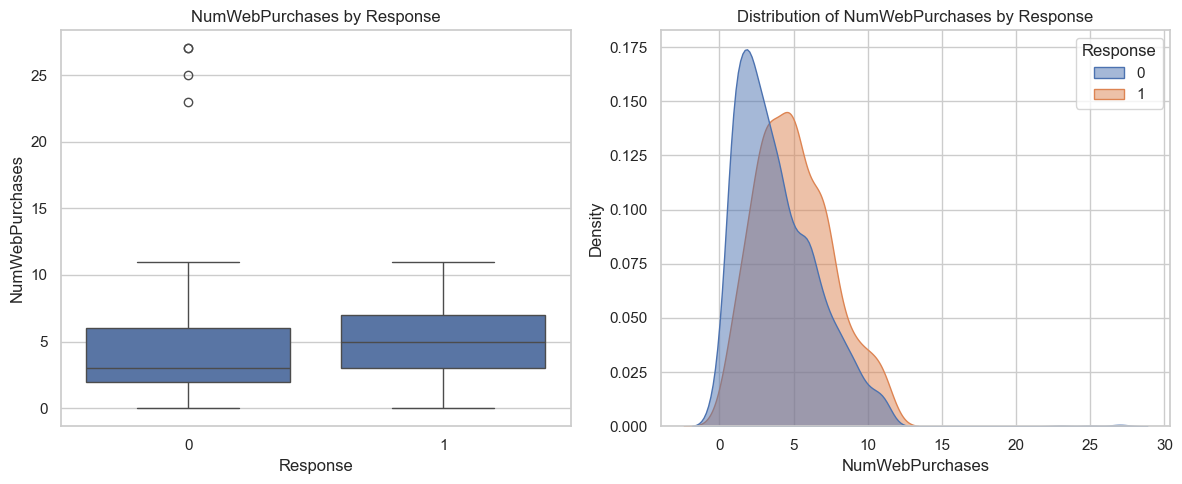

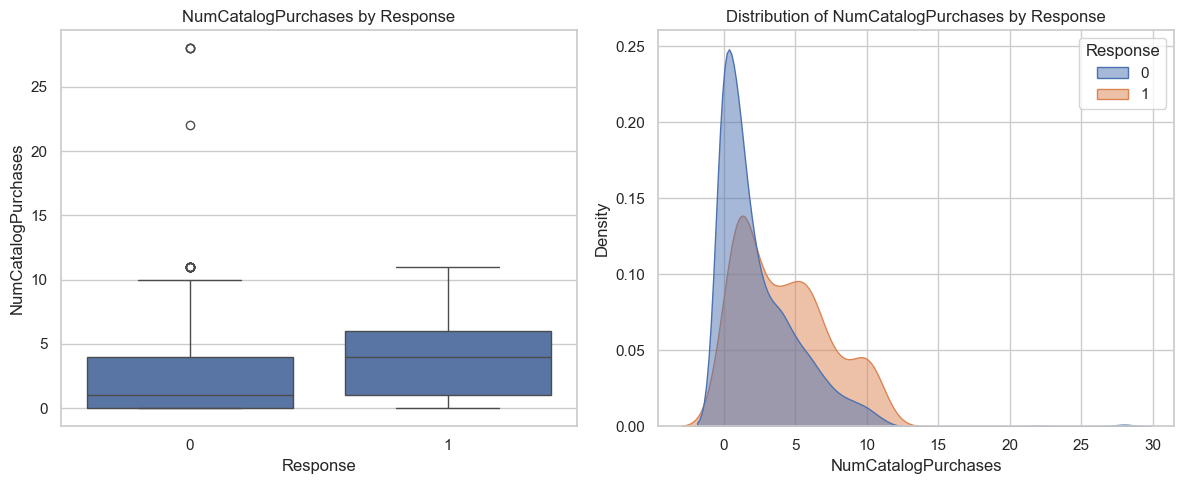

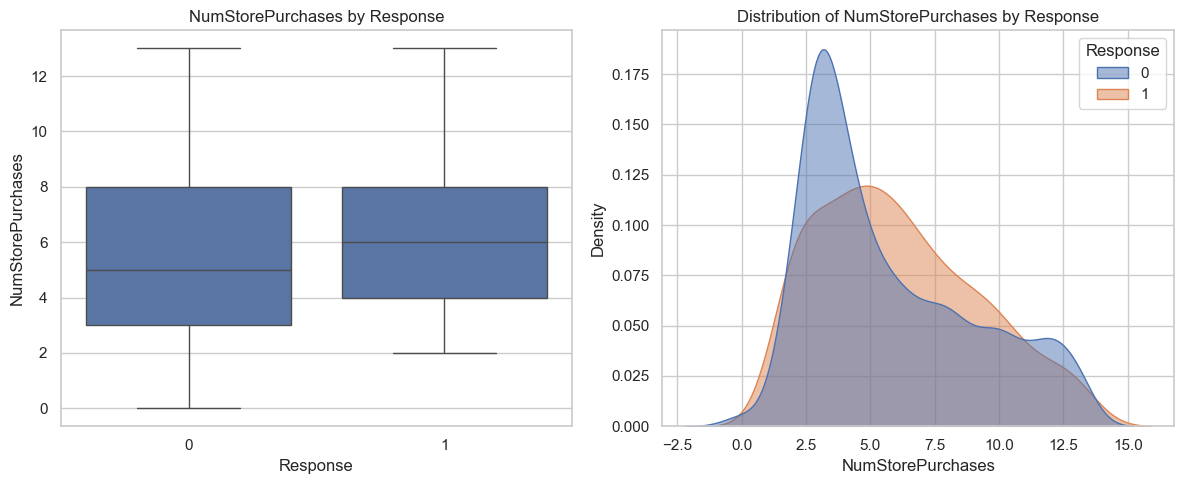

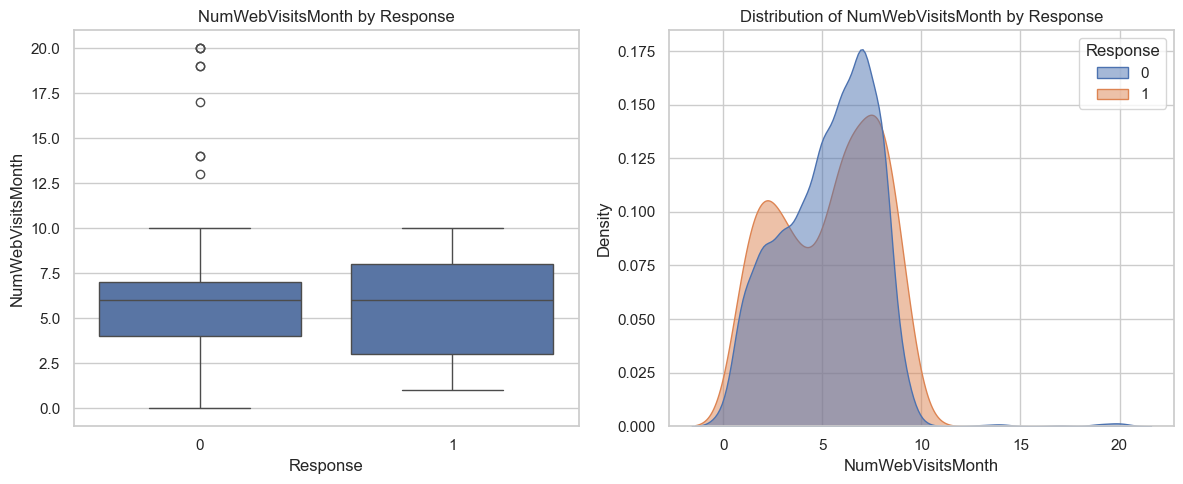

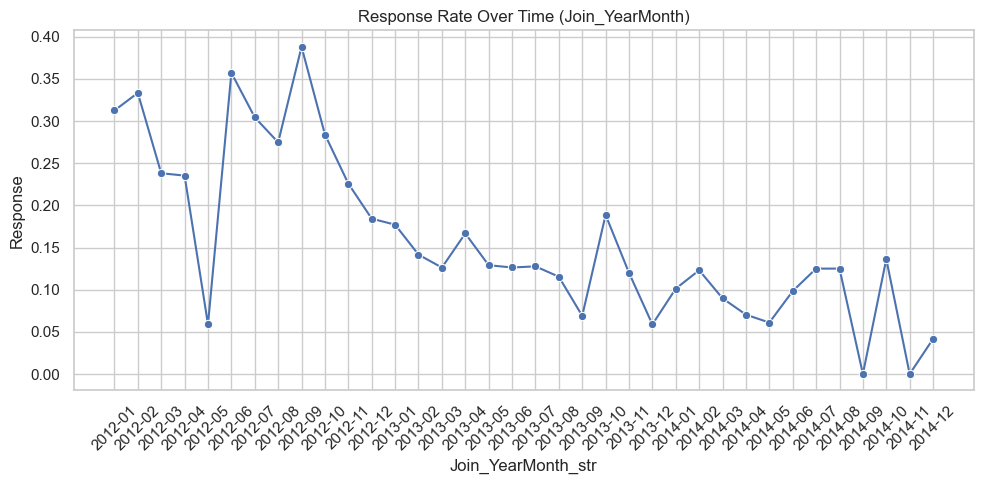

In [7]:
# Set style
sns.set(style="whitegrid")

# -------------------------------------------------
# Identify column types
# -------------------------------------------------
target = "Response"

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
categorical_cols += ["Complain", "Kidhome", "Teenhome"]  # small int categorical
categorical_cols = [col for col in categorical_cols if col in df.columns and col != target]

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in [target, "Complain", "Kidhome", "Teenhome"]]

time_cols = ["Join_YearMonth"] if "Join_YearMonth" in df.columns else []

# -------------------------------------------------
# 1. TARGET DISTRIBUTION
# -------------------------------------------------
plt.figure(figsize=(5,4))
sns.countplot(data=df, x=target)
plt.title("Target Distribution (Response)")
plt.show()

# -------------------------------------------------
# 2. CATEGORICAL VS TARGET
# -------------------------------------------------
for col in categorical_cols:
    plt.figure(figsize=(7,5))
    sns.countplot(data=df, x=col, hue=target)
    plt.title(f"{col} vs {target}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# 3. NUMERIC VS TARGET (Boxplots + KDE)
# -------------------------------------------------
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # Boxplot
    sns.boxplot(data=df, x=target, y=col, ax=axes[0])
    axes[0].set_title(f"{col} by {target}")

    # KDE Plot
    sns.kdeplot(data=df, x=col, hue=target, fill=True, common_norm=False, alpha=0.5, ax=axes[1])
    axes[1].set_title(f"Distribution of {col} by {target}")

    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# 4. TIME-BASED RELATIONSHIP (Join_YearMonth)
# -------------------------------------------------
if "Join_YearMonth" in df.columns:
    df_time = df.copy()
    df_time["Join_YearMonth_str"] = df_time["Join_YearMonth"].astype(str)

    trend = (
        df_time.groupby("Join_YearMonth_str")["Response"]
        .mean()
        .reset_index()
        .sort_values("Join_YearMonth_str")
    )

    plt.figure(figsize=(10,5))
    sns.lineplot(data=trend, x="Join_YearMonth_str", y="Response", marker="o")
    plt.title("Response Rate Over Time (Join_YearMonth)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



**Interpretation Notes:**  
Density/violin plots reflect distribution shape, not percentage of responders.  
Cohort line charts reflect response rate within each Join_YearMonth group.


<Axes: >

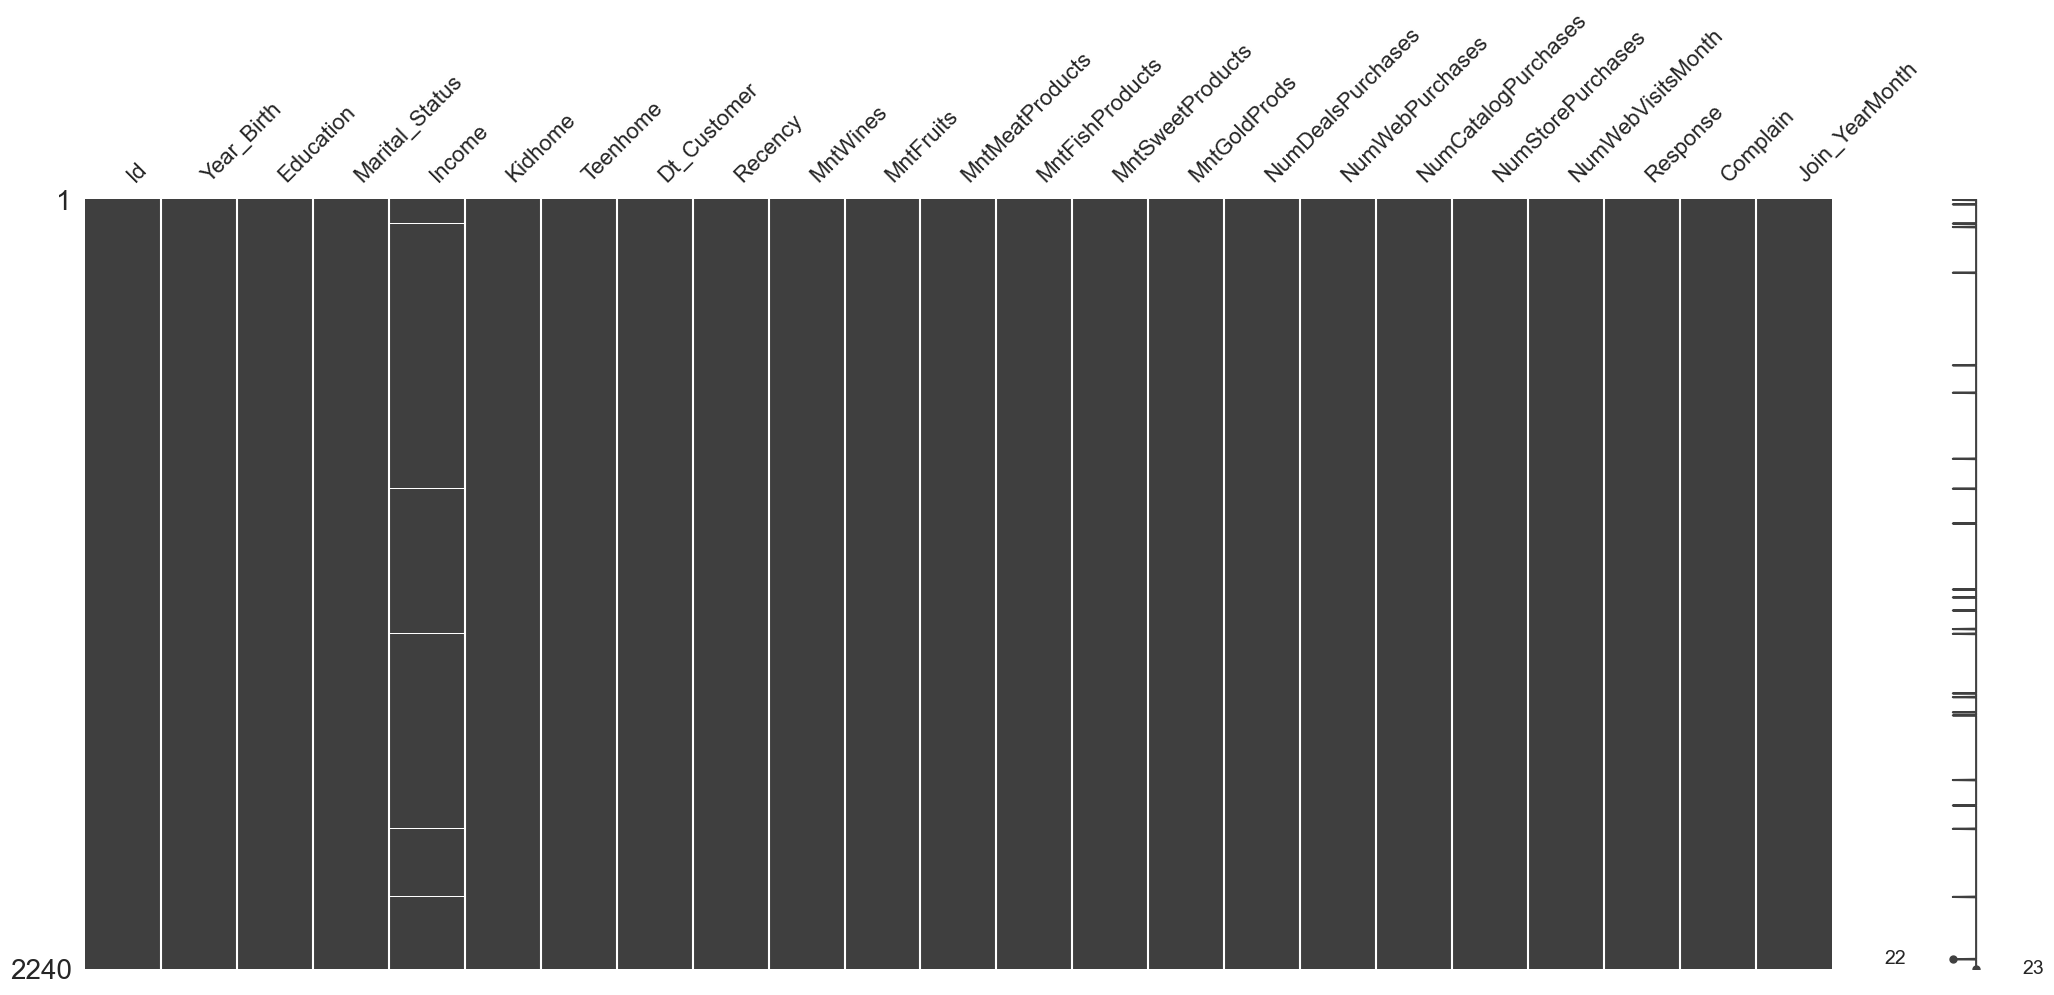

In [8]:
# Generate a matrix plot to review for missing values
msno.matrix(df)

### Section 1 Overview:

**Data Structure & Quality**  
There are 2240 records in this dataset. The dataset shows consistent schema definition, but several categorical fields contain noisy or non-standard labels (e.g., “YOLO,” “Absurd,” “2n Cycle”), indicating the need for consolidation and cleanup before modeling. Lastly, there's also missing values in the Income field that will need to be treated before modeling. 

**Target Distribution**  
The Response variable is imbalanced, with a smaller proportion of positive responses, which may require balancing strategies or weighted models in later steps.

**Feature Insights**  
Spending-related variables (especially wine, meat, and total spend) show clear separation between responders and non-responders, suggesting strong predictive potential, while features like fruit spending, household composition, and deal purchases display weaker or overlapping distributions. All of the spending-related variables exhibit strong right-skew with many zero-spend customers, which is typical with retail datasets.

**Potential Leakage Considerations**  
Because many behavioral fields appear as rolled-up totals, it is unclear whether they represent pre-response or post-response activity; in a real-world setting, only time-aligned historical data available prior to the response event should be used to avoid leakage.


## Section 2: Data Cleaning
---

* Remove duplicates and invalid rows  
* Correct data types (numeric, categorical, datetime)  
* Handle missing values (percent missing, drop vs. impute, optional missing-flag features)  
* Detect and treat outliers using IQR/z-score or domain rules  
* Standardize categorical labels and consolidate rare categories  
* Ensure consistent encoding across fields (e.g., Yes/No vs. 1/0)


### Duplicates

In [9]:
#  Check for Duplicate Rows
df.duplicated(['Id']).value_counts()

False    2240
Name: count, dtype: int64

No duplicate entries

### Correct Data Types

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

The field Dt_Customer was updated to a datetime field in section 1. This was the only change to the datatypes. 

### Missing Values

Only the Income field has missing values. The missing values should be replaced the median value since the average is influenced by outlier data points. 

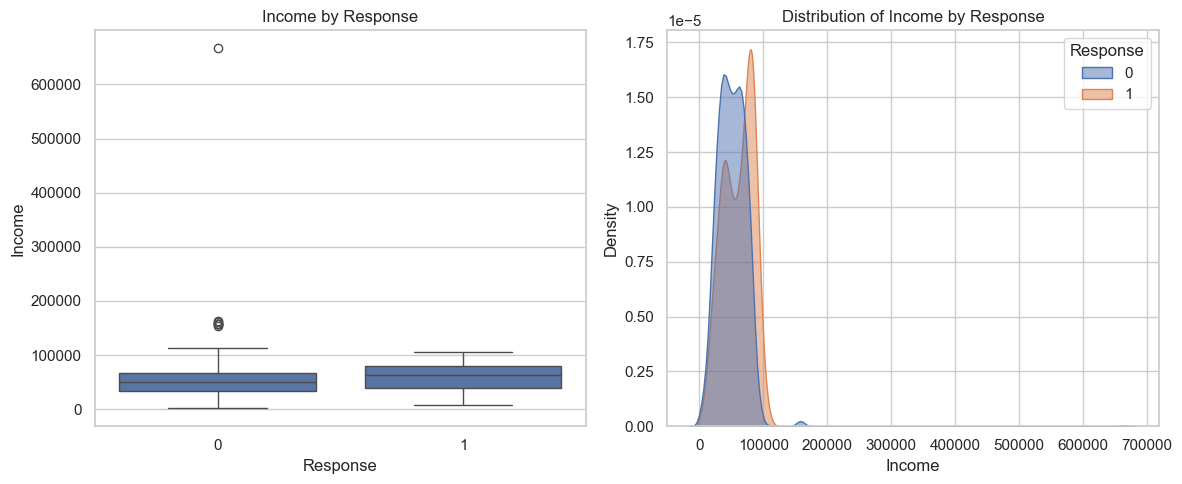

In [11]:
plt.figure(figsize=(12,5))

# --- Boxplot ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x="Response", y="Income")
plt.title("Income by Response")

# --- KDE Plot ---
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x="Income", hue="Response", fill=True, common_norm=False, alpha=0.5)
plt.title("Distribution of Income by Response")

plt.tight_layout()
plt.show()

In [12]:
df['Income'].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

In [13]:
median_income = float(np.median(df['Income'].dropna()))
median_income

51381.5

In [14]:
df['Income'] = df['Income'].fillna(median_income)

df['Income'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2240 entries, 0 to 2239
Series name: Income
Non-Null Count  Dtype  
--------------  -----  
2240 non-null   float64
dtypes: float64(1)
memory usage: 17.6 KB


In [15]:
df['Income'].describe()

count      2240.000000
mean      52237.975446
std       25037.955891
min        1730.000000
25%       35538.750000
50%       51381.500000
75%       68289.750000
max      666666.000000
Name: Income, dtype: float64

### Check and fix outliers 

In [16]:
# Save a copy of the df before outlier detection and replacement 
df_original = df.copy() 

Year_Birth: 3 outliers replaced


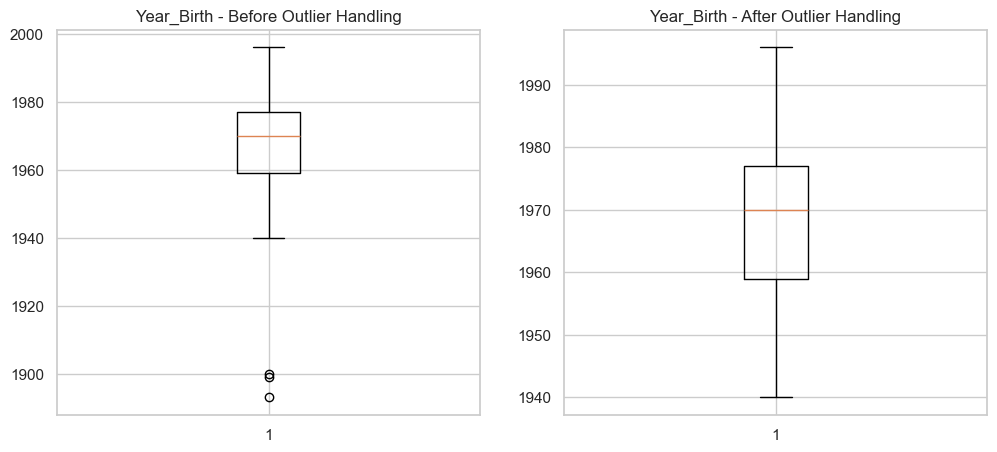

Income: 8 outliers replaced


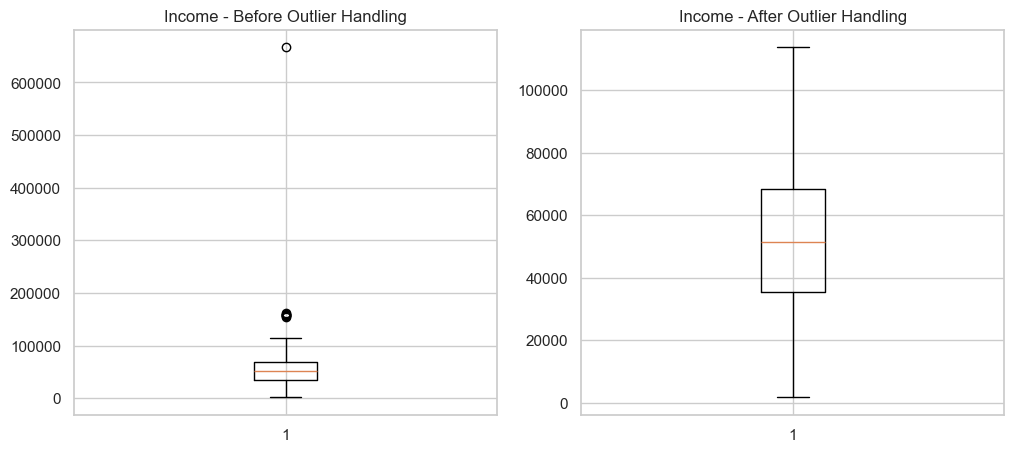

Recency: 0 outliers replaced


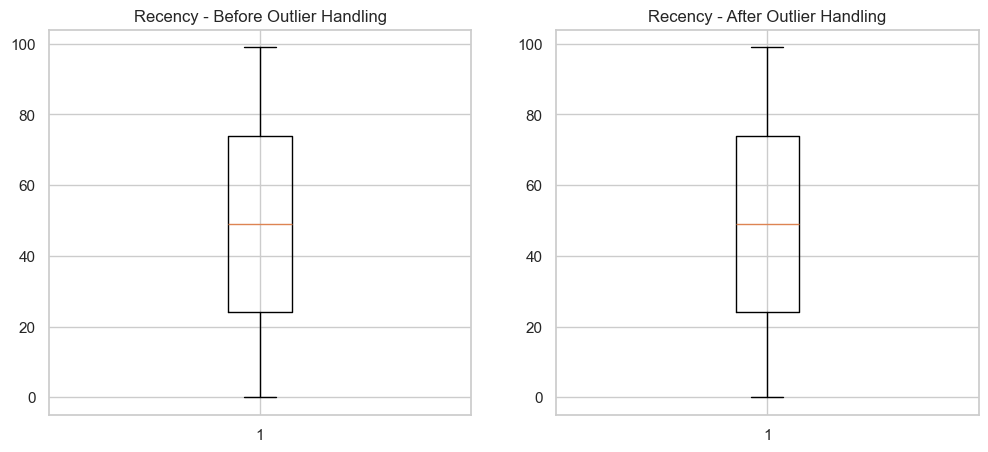

MntWines: 35 outliers replaced


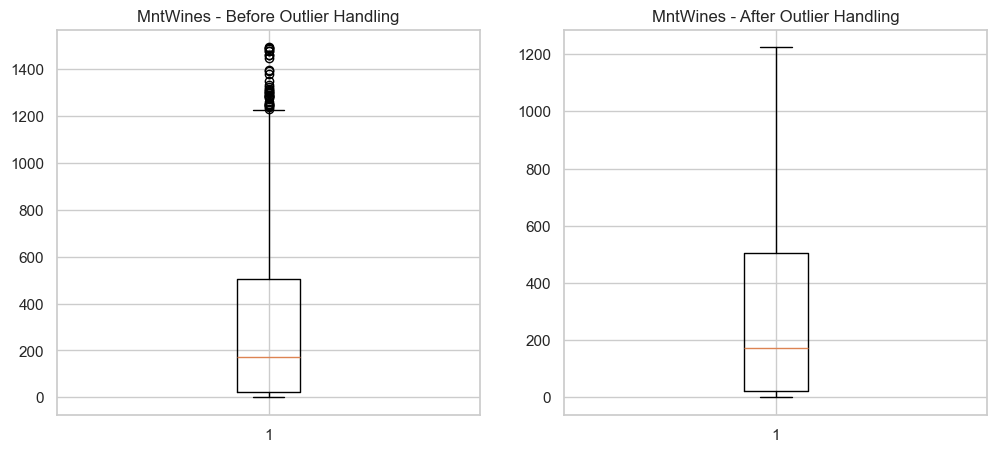

MntFruits: 227 outliers replaced


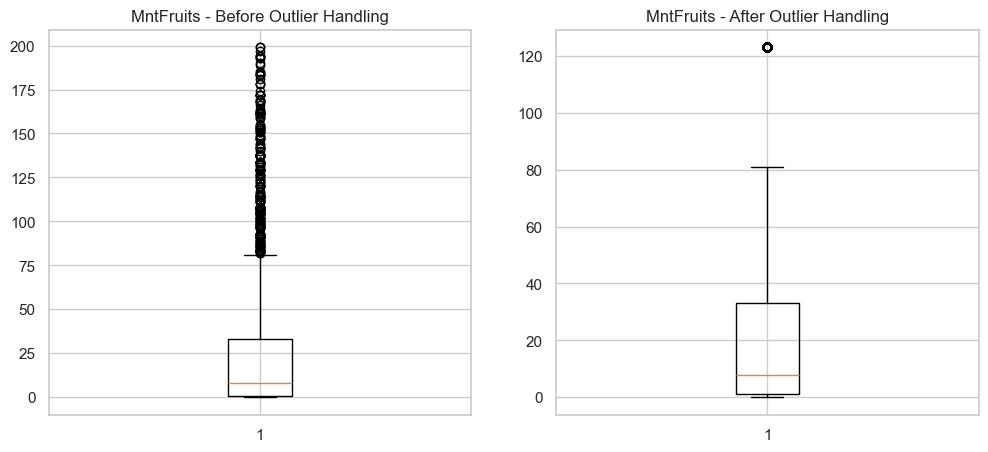

MntMeatProducts: 175 outliers replaced


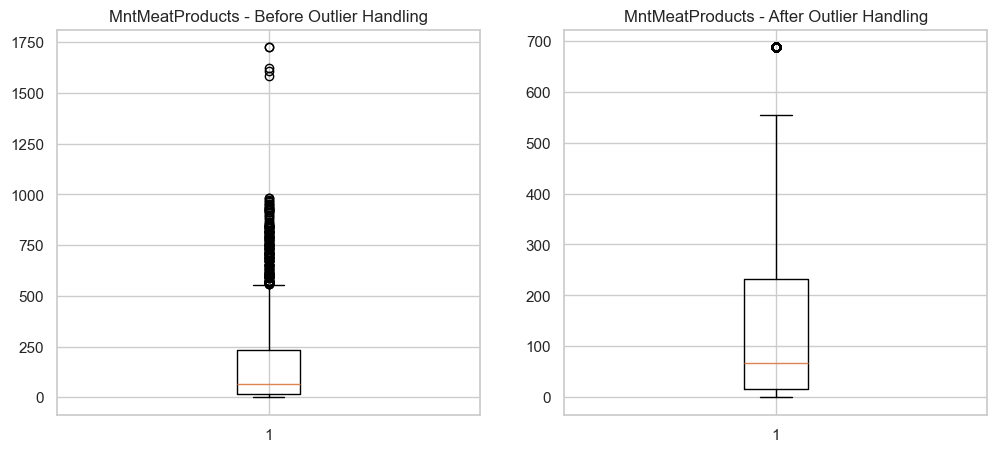

MntFishProducts: 223 outliers replaced


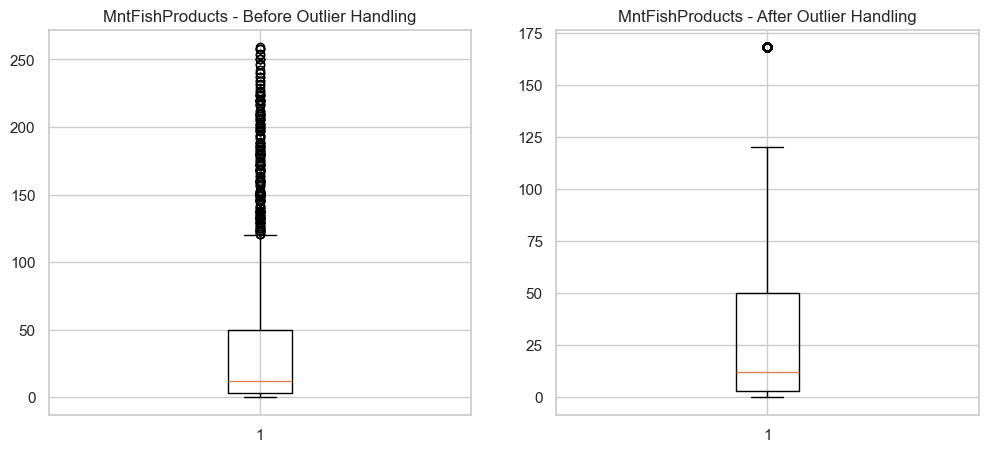

MntSweetProducts: 248 outliers replaced


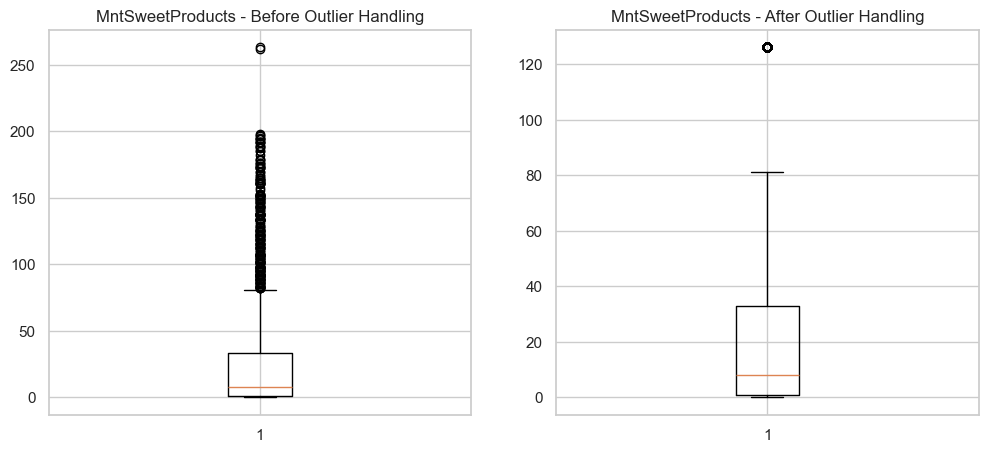

MntGoldProds: 207 outliers replaced


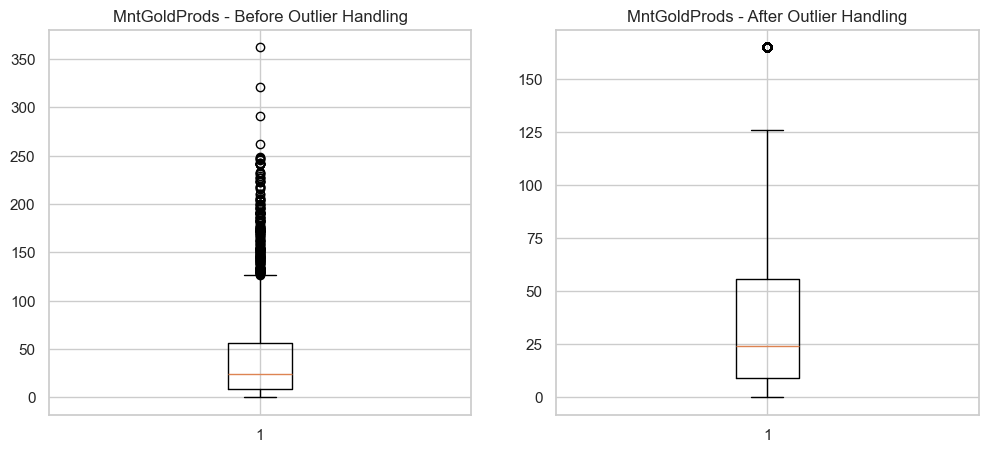

NumDealsPurchases: 86 outliers replaced


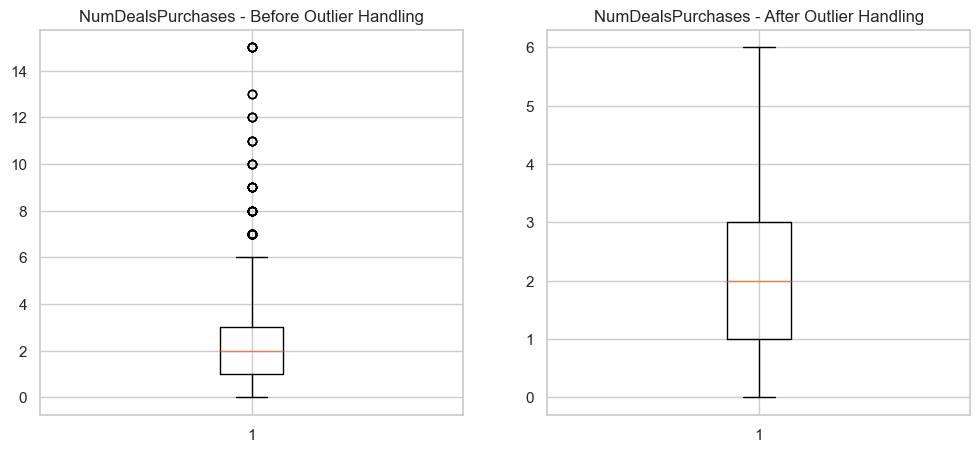

NumWebPurchases: 4 outliers replaced


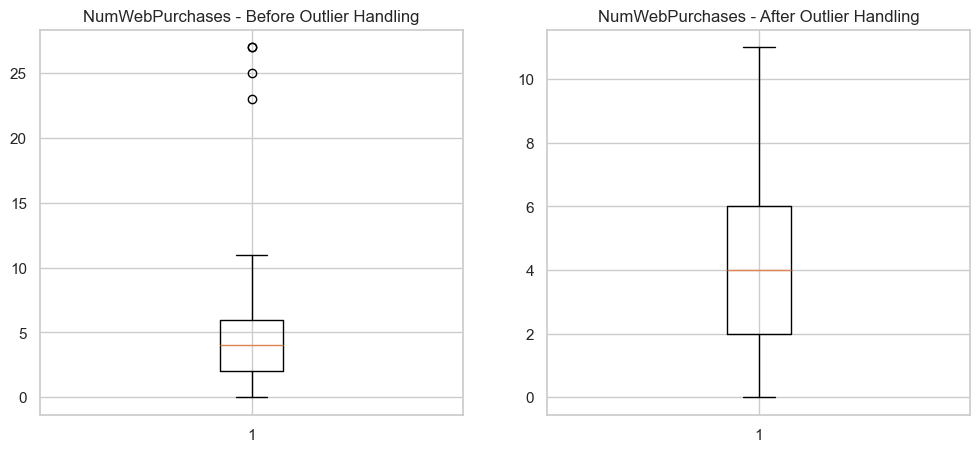

NumCatalogPurchases: 23 outliers replaced


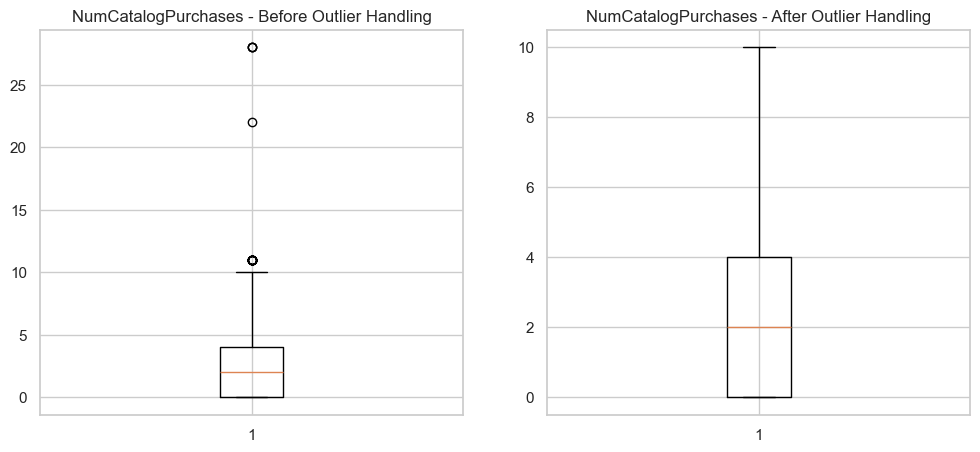

NumStorePurchases: 0 outliers replaced


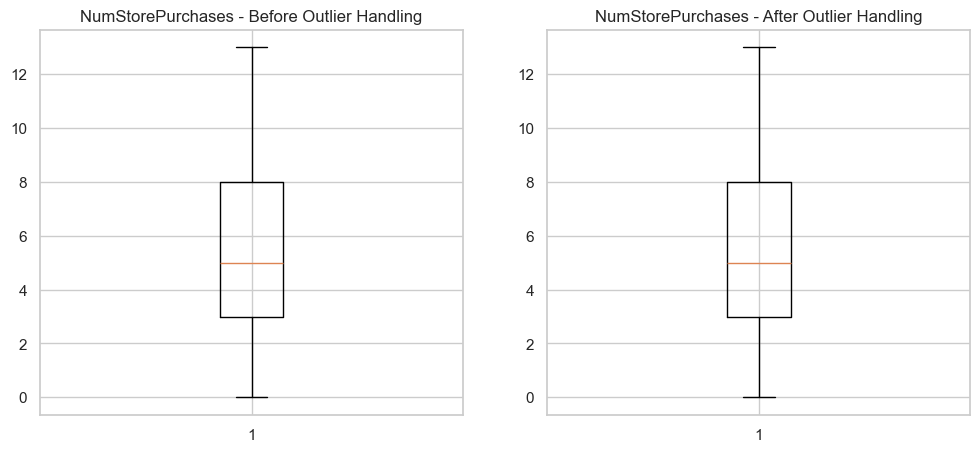

NumWebVisitsMonth: 8 outliers replaced


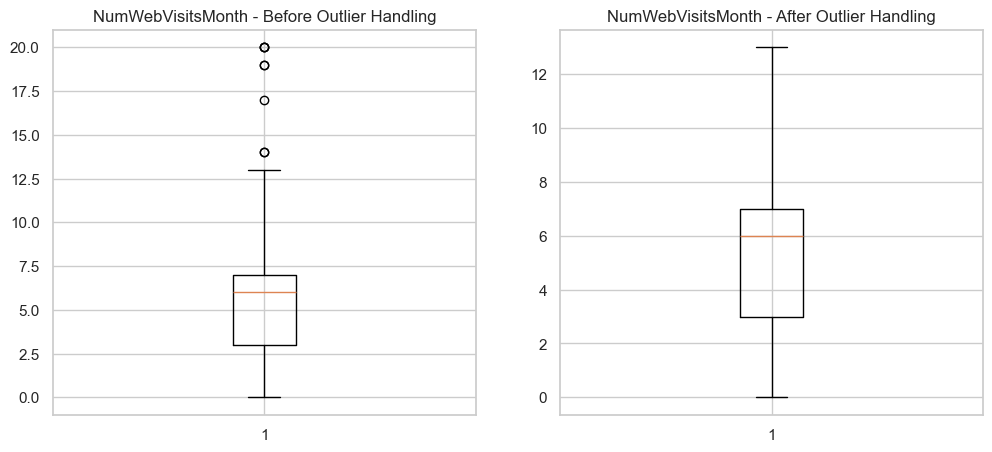

In [17]:
# Columns to ignore
ignore_cols = ['Response', 'Marital_Status', 'Education', 'Id', 'Complain', 'Kidhome', 'Teenhome']

# Numeric columns to process
num_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in ignore_cols]

# Loop through each numeric column
for col in num_cols:
    # Copy column for "before" boxplot
    before = df[col].copy()
    
    # Calculate IQR bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Define caps at 5th and 95th percentiles
    low_cap = df[col].quantile(0.05)
    high_cap = df[col].quantile(0.95)
    
    # Count outliers before replacement
    num_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    
    # Replace outliers
    df[col] = df[col].apply(lambda x: low_cap if x < lower else high_cap if x > upper else x)
    
    # Copy column for "after" boxplot
    after = df[col]
    
    # Print summary
    print(f"{col}: {num_outliers} outliers replaced")
    
    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].boxplot(before)
    axes[0].set_title(f"{col} - Before Outlier Handling")
    
    axes[1].boxplot(after)
    axes[1].set_title(f"{col} - After Outlier Handling")
    
    plt.show()


### Standardize categorical labels

The two categorical fields, Education & Marital_Status need to remove the noisy values identified in the exploratory analysis. 

In [18]:
# Update Categorical strings to update the weird responses to an unknown option
# Education:  2n Cycle >> Unknown
# Marital_Status: Yolo, Absurd >> Unknown,  Alone >> Single, Together >> Married

df['Education'] = df['Education'].replace({'2n Cycle': 'Unknown'})
df['Marital_Status'] = df['Marital_Status'].replace({'YOLO':'Unknown', 'Absurd':'Unknown', 'Alone':'Single', 'Together':'Married'})

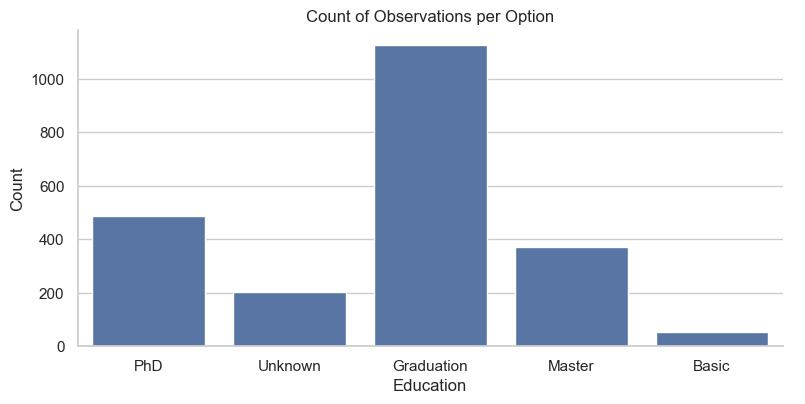

In [19]:
sns.catplot(x='Education', kind='count', data=df, height=4, aspect=2)
plt.title('Count of Observations per Option')
plt.xlabel('Education')
plt.ylabel('Count')
plt.show()

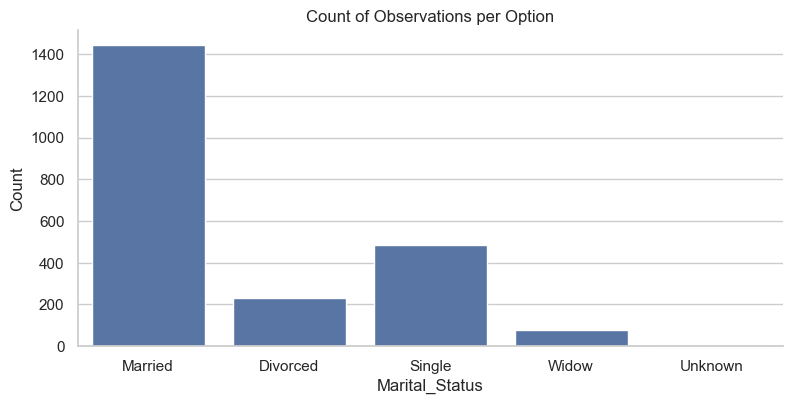

In [20]:
sns.catplot(x='Marital_Status', kind='count', data=df, height=4, aspect=2)
plt.title('Count of Observations per Option')
plt.xlabel('Marital_Status')
plt.ylabel('Count')
plt.show()

### Ensure consistent encoding across fields (e.g., Yes/No vs. 1/0)

In [21]:
binary_fields = ["Response", "Complain"]

for col in binary_fields:
    unique_vals = sorted(df[col].unique())
    print(f"{col} unique values: {unique_vals}")
    
    # Check if values are only 0 and 1
    if set(unique_vals).issubset({0,1}):
        print(f"✅ {col} is clean (binary 0/1)\n")
    else:
        print(f"⚠️ {col} contains unexpected values — needs standardization\n")


Response unique values: [0, 1]
✅ Response is clean (binary 0/1)

Complain unique values: [0, 1]
✅ Complain is clean (binary 0/1)



### Section 2 Review

**Duplicates**  
All rows were checked for duplicates and invalid entries; no duplicate records were found, so no removals were required.

**Data Types**  
Field types were validated and corrected to ensure numeric, categorical, and datetime columns were properly interpreted for downstream analysis.

**Missing Values**  
Only `Income` contained missing values, which were imputed using the median to maintain distributional shape without introducing bias.

**Outlier Detection & Treatment**  
Outliers were reviewed across `Year_Birth`, `Income`, all spend variables, purchase counts, and `Total_Spent`; values were corrected or clipped where necessary to remove implausible extremes while preserving legitimate customer behavior patterns.

**Categorical Standardization**  
Noisy or inconsistent category labels in `Education` and `Marital_Status` were consolidated into an “Unknown” category to stabilize encoding and reduce sparsity.

**Encoding Consistency**  
Binary fields (`Response`, `Complain`) were validated to ensure consistent 0/1 encoding, and no corrective action was needed.


## 3. Feature Preparation

*   Create age categorical field
*   create tenure months categorical field
*   Check correlations & multicollinearity
*   Consolidate & finalize numeric fields
*   Fix Numeric skewness
*   Encode categorical variables
*   Return final clean dataset that's ready for modeling

### Create Age Field & Bin for feature preperation

Age doesn't visually appear to have a strong influence over the target response. We will categorize the information to see if the influence isn't more apparent with the binned values. 

In [22]:
# Update the field Year_Birth to bins
# Compute age as of 2015
df['Age'] = 2015 - df['Year_Birth']

# Define age bins and labels
bins = [0, 24, 34, 44, 54, 64, float('inf')]  # last bin = 65+
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Bin the ages
df['Age_Bin'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# Verify
print(df[['Year_Birth', 'Age', 'Age_Bin']].head(10))
 

   Year_Birth   Age Age_Bin
0      1982.0  33.0   25-34
1      1973.0  42.0   35-44
2      1978.0  37.0   35-44
3      1975.0  40.0   35-44
4      1949.0  66.0     65+
5      1966.0  49.0   45-54
6      1977.0  38.0   35-44
7      1960.0  55.0   55-64
8      1952.0  63.0   55-64
9      1962.0  53.0   45-54


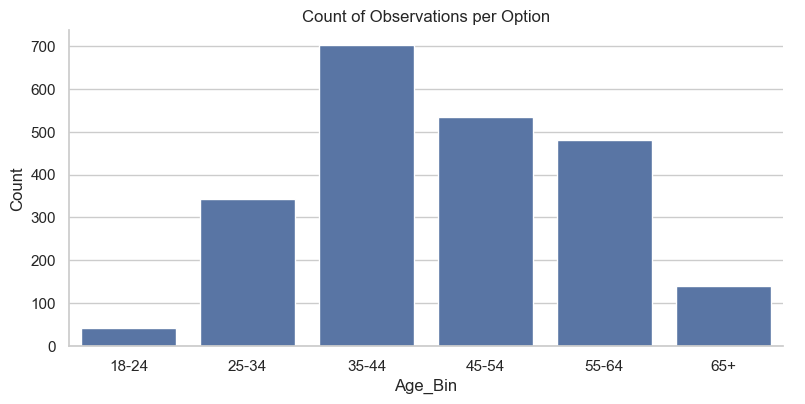

In [23]:
sns.catplot(x='Age_Bin', kind='count', data=df, height=4, aspect=2)
plt.title('Count of Observations per Option')
plt.xlabel('Age_Bin')
plt.ylabel('Count')
plt.show()

In [24]:
df.drop(columns=['Year_Birth', 'Age'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   2240 non-null   int64         
 1   Education            2240 non-null   object        
 2   Marital_Status       2240 non-null   object        
 3   Income               2240 non-null   float64       
 4   Kidhome              2240 non-null   int64         
 5   Teenhome             2240 non-null   int64         
 6   Dt_Customer          2240 non-null   datetime64[ns]
 7   Recency              2240 non-null   int64         
 8   MntWines             2240 non-null   float64       
 9   MntFruits            2240 non-null   float64       
 10  MntMeatProducts      2240 non-null   float64       
 11  MntFishProducts      2240 non-null   float64       
 12  MntSweetProducts     2240 non-null   float64       
 13  MntGoldProds         2240 non-nul

### Create Tenure Bin Feature
Because Join_YearMonth shows a visually strong relationship with the target Response, it will be converted into a tenure feature so the model can use the underlying time-based signal.

In [25]:
# Ensure Dt_Customer is a datetime field
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])

# Reference date = most recent customer join date
ref_date = df["Dt_Customer"].max()

# Compute tenure in months
df["Tenure_Months"] = ((ref_date - df["Dt_Customer"]) / pd.Timedelta(days=30)).round().astype(int)


In [26]:
df["Tenure_Bin"] = pd.cut(
    df["Tenure_Months"],
    bins=[-1, 6, 12, 18, 24, 36],
    labels=["0-6", "7-12", "13-18", "19-24", "25-36"]
)


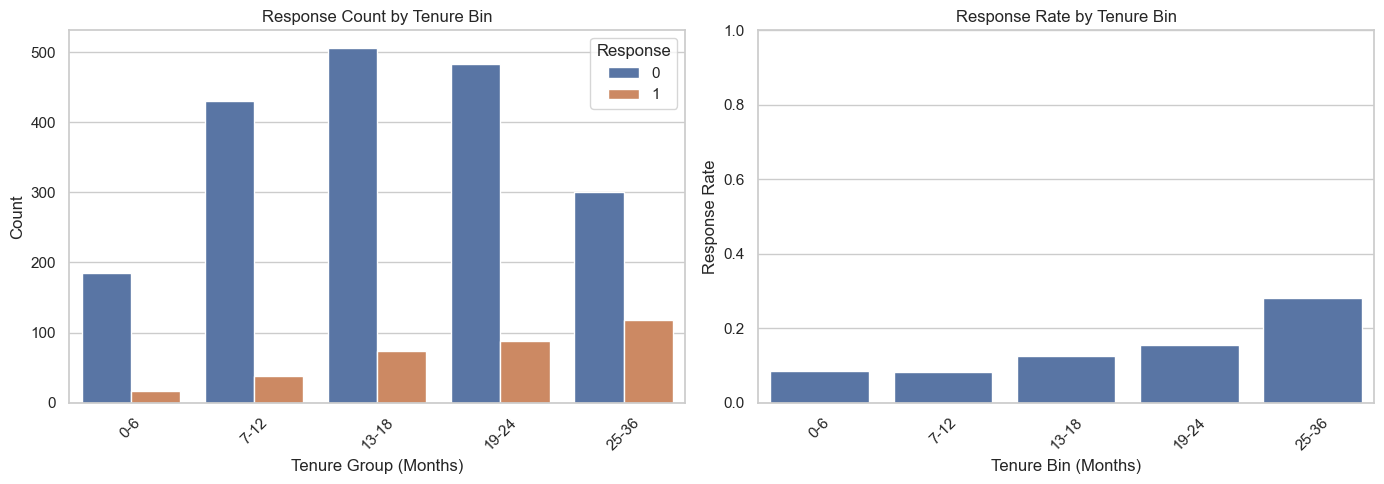

In [27]:
# --- Compute response rate ---
tenure_rate = (
    df.groupby("Tenure_Bin")["Response"]
    .mean()
    .reset_index()
    .rename(columns={"Response": "Response_Rate"})
)

# --- Set up figure with 2 columns ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Countplot ---
sns.countplot(data=df, x="Tenure_Bin", hue="Response", ax=axes[0])
axes[0].set_title("Response Count by Tenure Bin")
axes[0].set_xlabel("Tenure Group (Months)")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# --- Right: Proportion Plot (Response Rate) ---
sns.barplot(data=tenure_rate, x="Tenure_Bin", y="Response_Rate", ax=axes[1])
axes[1].set_title("Response Rate by Tenure Bin")
axes[1].set_xlabel("Tenure Bin (Months)")
axes[1].set_ylabel("Response Rate")
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [28]:
df.drop(columns=['Dt_Customer', 'Join_YearMonth', 'Tenure_Months'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Id                   2240 non-null   int64   
 1   Education            2240 non-null   object  
 2   Marital_Status       2240 non-null   object  
 3   Income               2240 non-null   float64 
 4   Kidhome              2240 non-null   int64   
 5   Teenhome             2240 non-null   int64   
 6   Recency              2240 non-null   int64   
 7   MntWines             2240 non-null   float64 
 8   MntFruits            2240 non-null   float64 
 9   MntMeatProducts      2240 non-null   float64 
 10  MntFishProducts      2240 non-null   float64 
 11  MntSweetProducts     2240 non-null   float64 
 12  MntGoldProds         2240 non-null   float64 
 13  NumDealsPurchases    2240 non-null   float64 
 14  NumWebPurchases      2240 non-null   float64 
 15  NumCatalogPurchases  

### Correlations & Multicollinearity 


In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def correlation_and_vif(df, target_col, vif_threshold=5.0):
    """
    Computes correlation with target and VIF for numeric features.
    
    Parameters:
    - df: pandas DataFrame
    - target_col: name of target column
    - vif_threshold: threshold to flag high multicollinearity
    
    Returns:
    - report_df: DataFrame with feature, correlation with target, VIF, and multicollinearity flag
    """
    # 1. Separate features from target
    feature_cols = [
    col for col in df.columns.drop(target_col)
    if df[col].dtype in ['int64', 'float64'] and df[col].var() > 0
    ]
    X = df[feature_cols].copy().astype(float)

    y = df[target_col]
    
    # 2. Correlation with target
    corr_with_target = X.corrwith(y)
    
    # 3. Compute VIF
    vif_values = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # 4. Compile report
    report_df = pd.DataFrame({
        'Feature': feature_cols,
        'Correlation_with_Target': corr_with_target,
        'VIF': vif_values
    })
    
    # Flag high multicollinearity
    report_df['High_VIF'] = report_df['VIF'] > vif_threshold
    
    # Sort by absolute correlation descending
    report_df = report_df.reindex(report_df['Correlation_with_Target'].abs().sort_values(ascending=False).index)
    
    # Print summary
    print("Correlation and VIF Report (sorted by |correlation|):\n")
    print(report_df.to_string(index=False))
    print(f"\nFeatures with VIF > {vif_threshold} are flagged as 'High_VIF=True'.")
    
    return report_df


In [30]:
report = correlation_and_vif(df, target_col='Response', vif_threshold=5.0)


Correlation and VIF Report (sorted by |correlation|):

            Feature  Correlation_with_Target       VIF  High_VIF
    MntMeatProducts                 0.240552  5.405377      True
NumCatalogPurchases                 0.237401  6.360624      True
           MntWines                 0.237159  5.528390      True
            Recency                -0.198437  3.635214     False
             Income                 0.171030 19.773547      True
    NumWebPurchases                 0.161569  7.865162      True
           Teenhome                -0.154446  3.010662     False
       MntGoldProds                 0.148702  2.707840     False
   MntSweetProducts                 0.124783  3.047224     False
          MntFruits                 0.124096  3.066946     False
    MntFishProducts                 0.115377  3.416936     False
            Kidhome                -0.080008  3.218335     False
  NumStorePurchases                 0.039363  9.801791      True
                 Id                

#### Correlation & Multicollinearity Summary

- Combine the amount spent on product types into a single amount spent field
- Combine the number of purchase fields into a total number of purchases field
- Combine Kidhome & Teenhome into children in home field. 
- Review VIF after these transformations to determine if the field income can be kept or if it should be dropped. 

#### Combine all of the 'Spending' Columns into a total spent

In [31]:
spending_cols = ['MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spent'] = df[spending_cols].sum(axis=1)
print(df[['Total_Spent', 'MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].head(10))


   Total_Spent  MntWines  MntMeatProducts  MntFruits  MntFishProducts  \
0       782.10      55.0            687.1       16.0            17.00   
1       713.10      20.0            687.1        2.0             1.00   
2       759.10      32.0            687.1        2.0            12.00   
3         6.00       1.0              1.0        1.0             1.00   
4         8.00       2.0              2.0        1.0             1.00   
5       290.05      81.0             33.0        4.0             5.00   
6      1352.10     494.0            391.0      123.0           168.05   
7      1187.05     493.0            352.0      123.0           168.05   
8      1165.05     376.0            462.0       53.0           168.05   
9       944.05     318.0            407.0        8.0           168.05   

   MntSweetProducts  MntGoldProds  
0               3.0          4.00  
1               2.0          1.00  
2               4.0         22.00  
3               1.0          1.00  
4               

In [32]:
df.drop(columns=['MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], inplace=True)

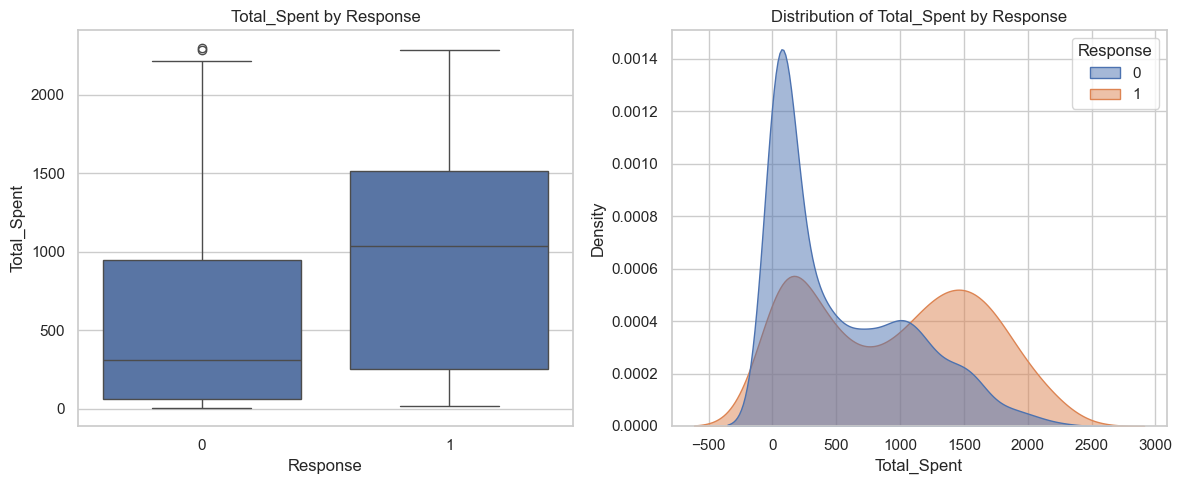

In [33]:
plt.figure(figsize=(12,5))

# --- Boxplot ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x="Response", y="Total_Spent")
plt.title("Total_Spent by Response")

# --- KDE Plot ---
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x="Total_Spent", hue="Response", fill=True, common_norm=False, alpha=0.5)
plt.title("Distribution of Total_Spent by Response")

plt.tight_layout()
plt.show()

#### Combine all the purchases into a total purchases feature

In [34]:
purchases_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Purchases'] = df[purchases_cols].sum(axis=1)
print(df[['Total_Purchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].head(10))


   Total_Purchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases
0             10.0              0.0                  9.0                  1
1              9.0              0.0                  9.0                  0
2              1.0              0.0                  0.0                  1
3              0.0              0.0                  0.0                  0
4              0.0              0.0                  0.0                  0
5             11.0              9.0                  1.0                  1
6             17.0              3.0                  4.0                 10
7             21.0              3.0                  5.0                 13
8             16.0              2.0                  7.0                  7
9             23.0              2.0                  8.0                 13


In [35]:
df.drop(columns=['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], inplace=True)


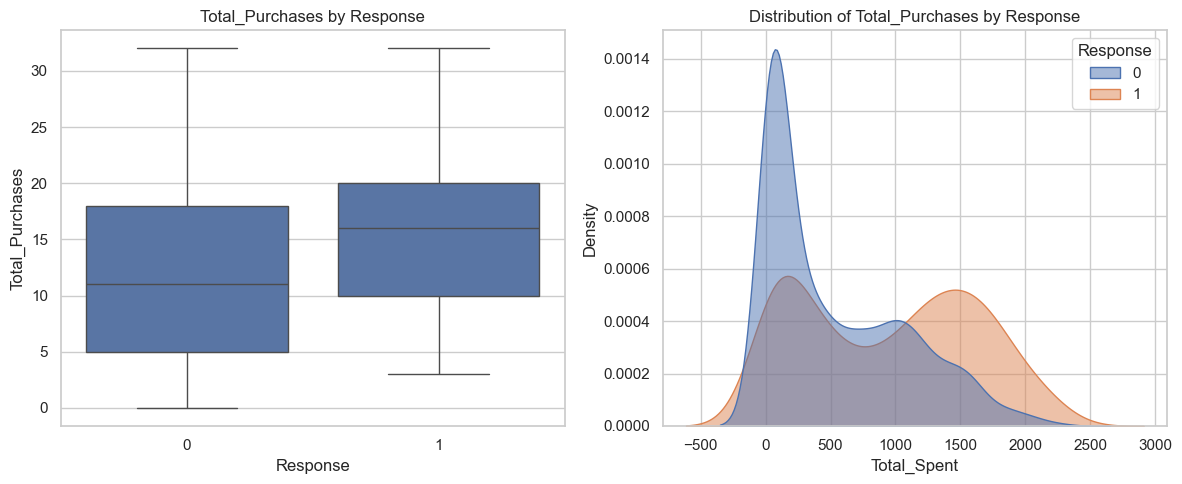

In [36]:
plt.figure(figsize=(12,5))

# --- Boxplot ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x="Response", y="Total_Purchases")
plt.title("Total_Purchases by Response")

# --- KDE Plot ---
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x="Total_Spent", hue="Response", fill=True, common_norm=False, alpha=0.5)
plt.title("Distribution of Total_Purchases by Response")

plt.tight_layout()
plt.show()


#### Combine all Kidhome & Teenhome for a Children field

In [37]:
purchases_cols = ['Kidhome', 'Teenhome']
df['Children'] = df[purchases_cols].sum(axis=1)
print(df[['Children', 'Kidhome', 'Teenhome']].head(10))


   Children  Kidhome  Teenhome
0         0        0         0
1         1        0         1
2         0        0         0
3         0        0         0
4         0        0         0
5         2        0         2
6         0        0         0
7         0        0         0
8         0        0         0
9         0        0         0


In [38]:
df.drop(columns=['Kidhome', 'Teenhome'], inplace=True)


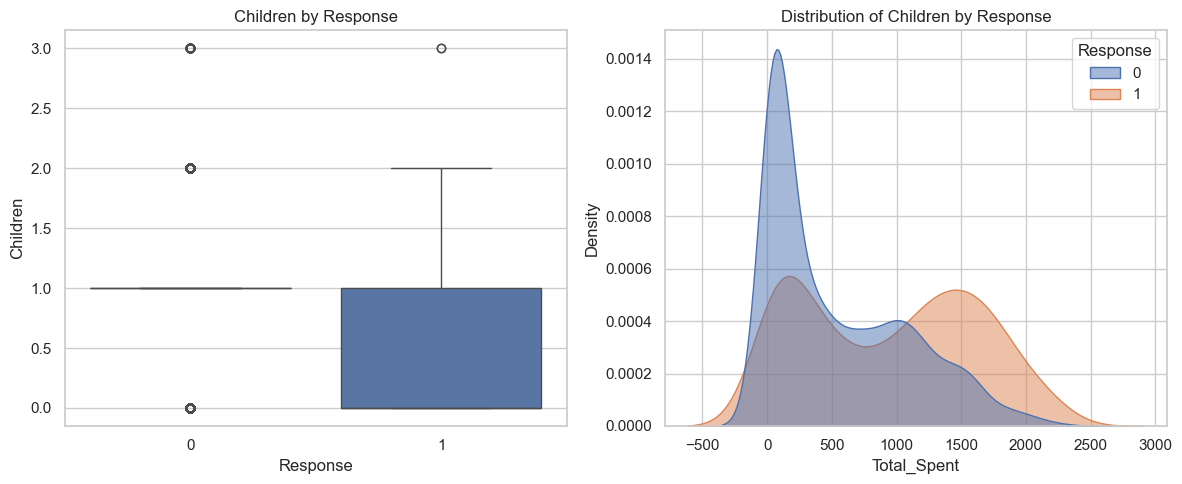

In [39]:
plt.figure(figsize=(12,5))

# --- Boxplot ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x="Response", y="Children")
plt.title("Children by Response")

# --- KDE Plot ---
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x="Total_Spent", hue="Response", fill=True, common_norm=False, alpha=0.5)
plt.title("Distribution of Children by Response")

plt.tight_layout()
plt.show()

#### Report 2

In [40]:
# Optional: re-run correlation and VIF to confirm
report2 = correlation_and_vif(df, target_col='Response', vif_threshold=5.0)


Correlation and VIF Report (sorted by |correlation|):

          Feature  Correlation_with_Target       VIF  High_VIF
      Total_Spent                 0.255961  9.933991      True
          Recency                -0.198437  3.562260     False
           Income                 0.171030 18.645353      True
         Children                -0.169163  5.270297      True
  Total_Purchases                 0.167653 18.215125      True
               Id                -0.021968  3.689237     False
NumDealsPurchases                -0.004904  5.571959      True
NumWebVisitsMonth                 0.002206  6.189701      True
         Complain                -0.001707  1.012892     False

Features with VIF > 5.0 are flagged as 'High_VIF=True'.


#### Correlation & Multicollinearity Report 2 Summary

- It's better to keep behavioral data vs demographic data in this scenario.  The behavioral datapoints are Total_spent, Total_Purchases, NumWebVisitsMonth, NumDealsPurchases
- Demographic details are Income, Teenhome, Kidhome.
- Total_spent is the highest correlation with target so this field should be kept
- NumDealsPurchases & NumWebVisitsMonth have a higher VIF value and a low Correlation value so both should be dropped
- Both Income and Total_Purchases have a high VIF score. These are likely redundent to Total_spent so both should be dropped.
  


In [41]:
# Drop columns
df.drop(columns=['Income', 'Total_Purchases', 'NumDealsPurchases', 'NumWebVisitsMonth'], inplace=True)
report3 = correlation_and_vif(df, target_col='Response', vif_threshold=5.0)

Correlation and VIF Report (sorted by |correlation|):

    Feature  Correlation_with_Target      VIF  High_VIF
Total_Spent                 0.255961 1.932923     False
    Recency                -0.198437 2.979517     False
   Children                -0.169163 2.316580     False
         Id                -0.021968 2.879840     False
   Complain                -0.001707 1.012309     False

Features with VIF > 5.0 are flagged as 'High_VIF=True'.


#### Correlation & Multicollinearity Report 3 Summary
All Correlation and Multicollinearity issues have been resolved

### Transform Numeric Variables

*   Evaluate for skew
*   Evaluate for scale
*   Transform both as needed 
*   Report changes 

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              2240 non-null   int64   
 1   Education       2240 non-null   object  
 2   Marital_Status  2240 non-null   object  
 3   Recency         2240 non-null   int64   
 4   Response        2240 non-null   int64   
 5   Complain        2240 non-null   int64   
 6   Age_Bin         2240 non-null   category
 7   Tenure_Bin      2240 non-null   category
 8   Total_Spent     2240 non-null   float64 
 9   Children        2240 non-null   int64   
dtypes: category(2), float64(1), int64(5), object(2)
memory usage: 144.9+ KB


In [43]:
from sklearn.preprocessing import StandardScaler, RobustScaler

def preprocess_numeric(df, ignore_cols=None, skew_threshold=1.0, transformation='log', scaling='standard'):
    """
    Handle skewed numeric features and scale them for modeling.

    Parameters:
    - df: pandas DataFrame
    - ignore_cols: list of columns to skip (e.g., target, booleans)
    - skew_threshold: absolute skewness above which to transform
    - transformation: 'log', 'sqrt', or 'boxcox'
    - scaling: 'standard' or 'robust'

    Returns:
    - df_scaled: DataFrame with transformed and scaled numeric features
    """
    if ignore_cols is None:
        ignore_cols = []

    # Select numeric columns to process
    num_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in ignore_cols]

    # Initialize scaler
    if scaling == 'standard':
        scaler = StandardScaler()
    elif scaling == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("scaling must be 'standard' or 'robust'")

    df_scaled = df.copy()
    
    for col in num_cols:
        data_before = df_scaled[col].copy()
        skewness_before = data_before.skew()
        transformation_applied = "None"

        # Transform if skewed
        if abs(skewness_before) > skew_threshold:
            if transformation == 'log':
                if (data_before <= 0).any():
                    df_scaled[col] = np.log1p(data_before)  # log(1+x) handles zeros
                    transformation_applied = "log1p"
                else:
                    df_scaled[col] = np.log(data_before)
                    transformation_applied = "log"
            elif transformation == 'sqrt':
                df_scaled[col] = np.sqrt(data_before.clip(lower=0))
                transformation_applied = "sqrt"
            elif transformation == 'boxcox':
                if (data_before <= 0).any():
                    transformation_applied = "Box-Cox not applied (non-positive values)"
                else:
                    df_scaled[col], _ = stats.boxcox(data_before)
                    transformation_applied = "Box-Cox"
        else:
            df_scaled[col] = data_before  # no transformation

        # Scale the column
        df_scaled[col] = scaler.fit_transform(df_scaled[[col]])

        # Plot before and after histograms
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.hist(data_before, bins=30, edgecolor='k', alpha=0.7)
        plt.title(f"{col} - Before\nSkewness: {skewness_before:.2f}")

        plt.subplot(1,2,2)
        plt.hist(df_scaled[col], bins=30, edgecolor='k', alpha=0.7)
        plt.title(f"{col} - After ({transformation_applied}, {scaling} scaled)")
        plt.show()

        print(f"{col}: Transformation -> {transformation_applied}, Scaling -> {scaling}")
        print("-"*60)
    
    return df_scaled


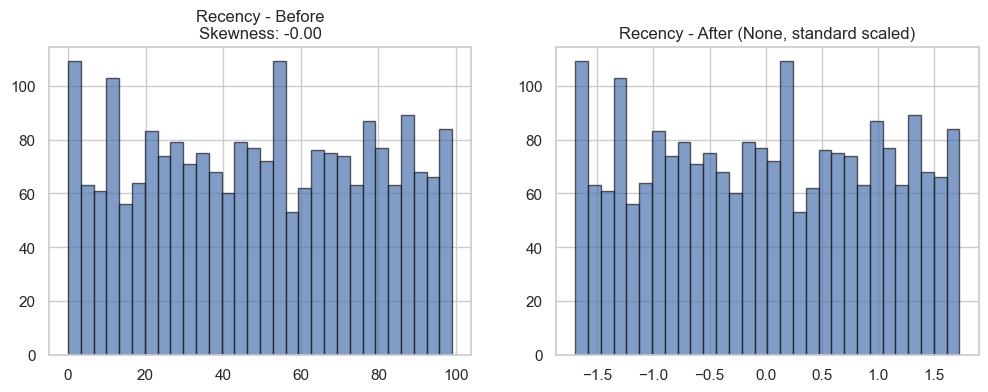

Recency: Transformation -> None, Scaling -> standard
------------------------------------------------------------


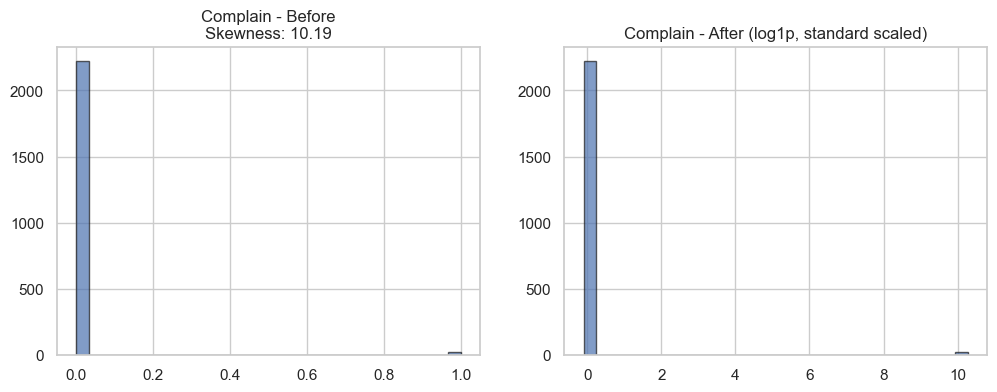

Complain: Transformation -> log1p, Scaling -> standard
------------------------------------------------------------


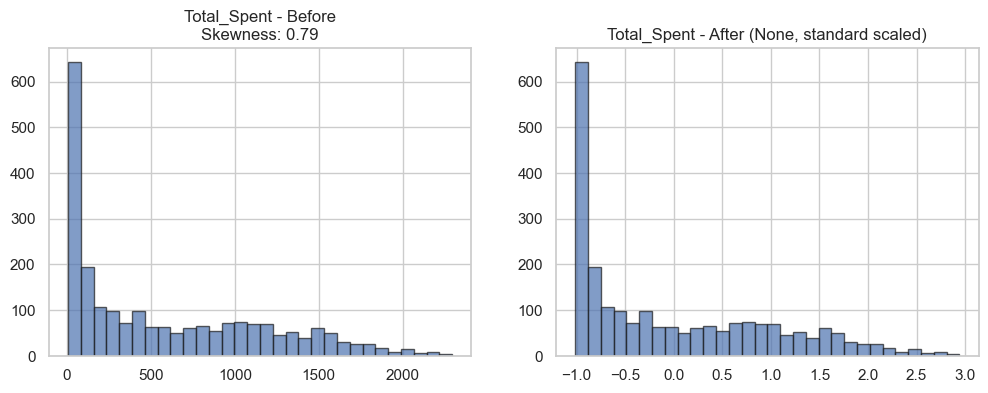

Total_Spent: Transformation -> None, Scaling -> standard
------------------------------------------------------------


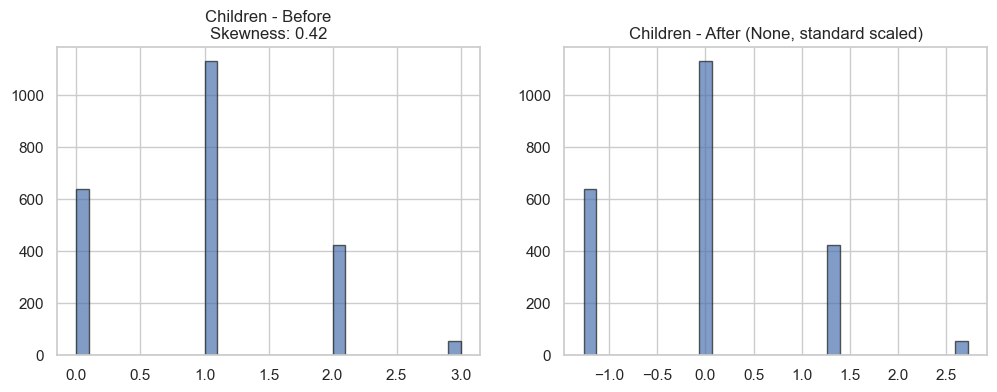

Children: Transformation -> None, Scaling -> standard
------------------------------------------------------------


In [44]:
df = preprocess_numeric(df, ignore_cols=['Id', 'Response'], transformation='log', scaling='standard')

### Encode Categorical Columns

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              2240 non-null   int64   
 1   Education       2240 non-null   object  
 2   Marital_Status  2240 non-null   object  
 3   Recency         2240 non-null   float64 
 4   Response        2240 non-null   int64   
 5   Complain        2240 non-null   float64 
 6   Age_Bin         2240 non-null   category
 7   Tenure_Bin      2240 non-null   category
 8   Total_Spent     2240 non-null   float64 
 9   Children        2240 non-null   float64 
dtypes: category(2), float64(4), int64(2), object(2)
memory usage: 144.9+ KB


In [46]:
# Detect categorical columns automatically
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns detected for encoding: {cat_cols}")

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Check the result
# print(f"Shape before encoding: {df.shape}")
# print(f"Shape after encoding: {df_encoded.shape}")
df.head()


Categorical columns detected for encoding: ['Education', 'Marital_Status', 'Age_Bin', 'Tenure_Bin']


,Id,Recency,Response,Complain,Total_Spent,Children,Education_Graduation,Education_Master,Education_PhD,Education_Unknown,...,Marital_Status_Widow,Age_Bin_25-34,Age_Bin_35-44,Age_Bin_45-54,Age_Bin_55-64,Age_Bin_65+,Tenure_Bin_7-12,Tenure_Bin_13-18,Tenure_Bin_19-24,Tenure_Bin_25-36
0,1501,-0.970762,0,-0.097282,0.327656,-1.264505,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True
1,8475,1.688446,0,-0.097282,0.208434,0.065928,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
2,8720,0.134363,0,-0.097282,0.287916,-1.264505,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False
3,5555,1.101348,0,-0.097282,-1.013330,-1.264505,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,11181,1.239489,0,-0.097282,-1.009874,-1.264505,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False


In [47]:
df['Response'] = df['Response'].astype(bool)
df['Complain'] = df['Complain'].astype(bool)

# Verify the changes
print(df[['Response', 'Complain']].dtypes)
df[['Response', 'Complain']].head()

Response    bool
Complain    bool
dtype: object


,Response,Complain
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      2240 non-null   int64  
 1   Recency                 2240 non-null   float64
 2   Response                2240 non-null   bool   
 3   Complain                2240 non-null   bool   
 4   Total_Spent             2240 non-null   float64
 5   Children                2240 non-null   float64
 6   Education_Graduation    2240 non-null   bool   
 7   Education_Master        2240 non-null   bool   
 8   Education_PhD           2240 non-null   bool   
 9   Education_Unknown       2240 non-null   bool   
 10  Marital_Status_Married  2240 non-null   bool   
 11  Marital_Status_Single   2240 non-null   bool   
 12  Marital_Status_Unknown  2240 non-null   bool   
 13  Marital_Status_Widow    2240 non-null   bool   
 14  Age_Bin_25-34           2240 non-null   

## 4. Data Splitting
   * Split dataset into train/test before target-informed steps
   * Use stratified split for classification
   * Optionally create validation set for tuning


In [49]:
# Drop ID from dataframe
df_model = df.drop(columns=['Id'])

# Features: drop the target
X = df_model.drop(columns=['Response'], axis=1)

# Target
y = df_model['Response']

customer_ids=df['Id']


In [50]:
from sklearn.model_selection import train_test_split

# Split into 80% train / 20% test (you can adjust)
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, customer_ids,
    test_size=0.2, 
    random_state=42,  # ensures reproducibility
    stratify=y         # keeps the same proportion of 0/1 in train and test
)


In [51]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))
print("id_train shape:", id_train.shape)
print("id_test shape:", id_test.shape)


X_train shape: (1792, 21)
X_test shape: (448, 21)
y_train distribution:
 Response
False    0.851004
True     0.148996
Name: proportion, dtype: float64
y_test distribution:
 Response
False    0.850446
True     0.149554
Name: proportion, dtype: float64
id_train shape: (1792,)
id_test shape: (448,)


## 5. Baseline & Imbalance Handling
   * Fit baseline (intercept-only or simple) logistic model
   * Examine baseline metrics
   * Address imbalance
       *   Class weights
       *   Oversampling / undersampling / SMOTE (training only)

#### Baseline and Model Tuning

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd

# -----------------------------
# Define numeric columns
numeric_cols = ['Recency', 'Total_Spent', 'Children']

# -----------------------------
# Define pipelines for baseline and tuned models
# Baseline: default L2 logistic regression
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=5000))
])

# Tuned logistic regression pipeline (GridSearchCV)
param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__solver': ['saga'],            # saga supports elasticnet and L1
    'logreg__C': [0.01, 0.1, 1, 10],       # regularization strength
    'logreg__class_weight': [None, 'balanced'],
    'logreg__l1_ratio': [0.0, 0.5, 1.0]    # only used if penalty='elasticnet'
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=5000, random_state=42))
    ]),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# -----------------------------
# Fit baseline model
baseline_pipeline.fit(X_train, y_train)
y_pred_base = baseline_pipeline.predict(X_test)
y_proba_base = baseline_pipeline.predict_proba(X_test)[:,1]

baseline_metrics = {
    'Model': 'Baseline',
    'Accuracy': accuracy_score(y_test, y_pred_base),
    'Precision': precision_score(y_test, y_pred_base),
    'Recall': recall_score(y_test, y_pred_base),
    'F1': f1_score(y_test, y_pred_base),
    'ROC-AUC': roc_auc_score(y_test, y_proba_base)
}

# -----------------------------
# Fit GridSearch (tuned) model
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_proba_tuned = best_model.predict_proba(X_test)[:,1]

tuned_metrics = {
    'Model': 'Tuned',
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1': f1_score(y_test, y_pred_tuned),
    'ROC-AUC': roc_auc_score(y_test, y_proba_tuned)
}

# -----------------------------
# Compile metrics into DataFrame
metrics_df = pd.DataFrame([baseline_metrics, tuned_metrics])
metrics_df = metrics_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)

print("🏆 Model Comparison by ROC-AUC:")
print(metrics_df)

# Optional: print confusion matrix & classification report for best model
print("\nConfusion Matrix (Best Model):\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred_tuned))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
🏆 Model Comparison by ROC-AUC:
      Model  Accuracy  Precision    Recall        F1   ROC-AUC
0     Tuned  0.723214   0.303448  0.656716  0.415094  0.793141
1  Baseline  0.868304   0.666667  0.238806  0.351648  0.792475

Confusion Matrix (Best Model):
 [[280 101]
 [ 23  44]]

Classification Report (Best Model):
               precision    recall  f1-score   support

       False       0.92      0.73      0.82       381
        True       0.30      0.66      0.42        67

    accuracy                           0.72       448
   macro avg       0.61      0.70      0.62       448
weighted avg       0.83      0.72      0.76       448



c:\Users\katie\anaconda3\envs\python310env\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


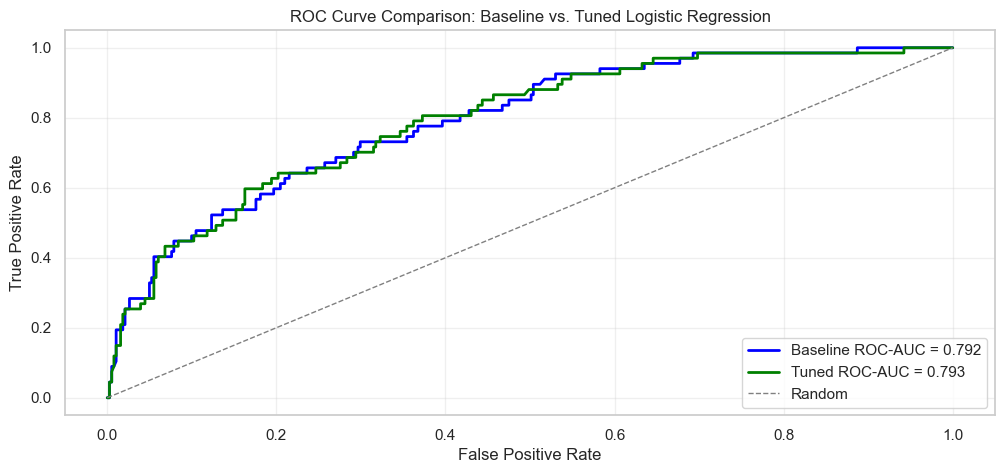

🏆 Best Performing Model:
Model: Tuned
ROC-AUC Score: 0.793

🔹 Model Comparison Table:
      Model  Accuracy  Precision    Recall        F1   ROC-AUC
0     Tuned  0.723214   0.303448  0.656716  0.415094  0.793141
1  Baseline  0.868304   0.666667  0.238806  0.351648  0.792475

💬 Interpretation:
- ROC-AUC is the recommended metric for imbalanced data.
- Baseline prioritizes precision (fewer false positives).
- Tuned model may improve recall (fewer missed positive customers).
- Choose the model depending on business need: prioritize catching positives (recall) vs. avoiding false alarms (precision).


In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -----------------------------
# ROC curve for Baseline
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
roc_auc_base = auc(fpr_base, tpr_base)

# ROC curve for Tuned
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# -----------------------------
# Plot side-by-side ROC curves
plt.figure(figsize=(12,5))

plt.plot(fpr_base, tpr_base, color='blue', lw=2, label=f'Baseline ROC-AUC = {roc_auc_base:.3f}')
plt.plot(fpr_tuned, tpr_tuned, color='green', lw=2, label=f'Tuned ROC-AUC = {roc_auc_tuned:.3f}')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Baseline vs. Tuned Logistic Regression')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# -----------------------------
# Summary metrics table
metrics_df = pd.DataFrame([baseline_metrics, tuned_metrics])
metrics_df = metrics_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)

print("🏆 Best Performing Model:")
print(f"Model: {metrics_df.loc[0, 'Model']}")
print(f"ROC-AUC Score: {metrics_df.loc[0, 'ROC-AUC']:.3f}\n")

print("🔹 Model Comparison Table:")
print(metrics_df)

print("\n💬 Interpretation:")
print("- ROC-AUC is the recommended metric for imbalanced data.")
print("- Baseline prioritizes precision (fewer false positives).")
print("- Tuned model may improve recall (fewer missed positive customers).")
print("- Choose the model depending on business need: prioritize catching positives (recall) vs. avoiding false alarms (precision).")


## Prep Export for calling promo team

In [55]:
# Step 1: Predict probabilities using the trained model
all_probabilities = tuned_model.predict_proba(X)[:, 1]

# Step 2: Attach probabilities to IDs
df_customers = pd.DataFrame({
    'Id': df['Id'],
    'Predicted_Probability': all_probabilities
})

# Step 3: Apply threshold
threshold = 0.5
df_customers['Predicted_Label'] = df_customers['Predicted_Probability'] >= threshold

# Step 4: Sort customers by probability
df_customers_sorted = df_customers.sort_values(by='Predicted_Probability', ascending=False)

# Step 5: View top 10
df_customers_sorted.head(10)



,Id,Predicted_Probability,Predicted_Label
929,8278,0.982650,True
279,1891,0.976046,True
2107,7919,0.975767,True
526,4530,0.975651,True
27,7962,0.972746,True
282,3698,0.970773,True
502,2114,0.968742,True
503,4261,0.968742,True
1358,3403,0.968395,True
434,10619,0.960298,True


In [ ]:
# Export to csv
# df_customers_sorted.to_csv("customer_likelihood_scores.csv", index=False)


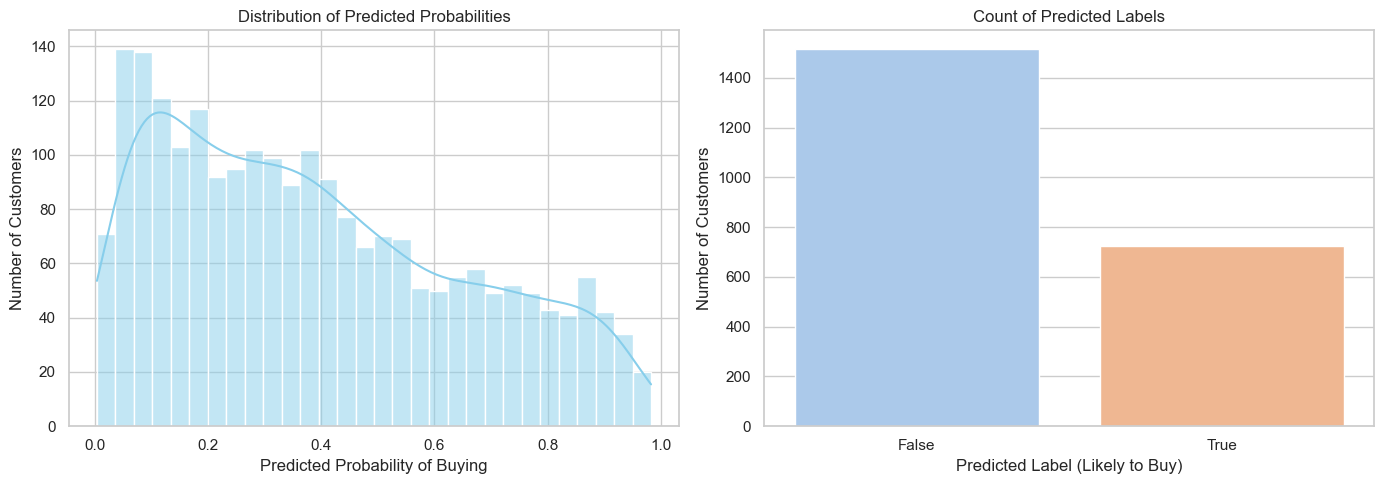

In [56]:
# Set up a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# 1️⃣ Histogram of predicted probabilities
sns.histplot(df_customers['Predicted_Probability'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title("Distribution of Predicted Probabilities")
axes[0].set_xlabel("Predicted Probability of Buying")
axes[0].set_ylabel("Number of Customers")

# 2️⃣ Count of predicted labels
sns.countplot(x='Predicted_Label', data=df_customers, palette='pastel', ax=axes[1])
axes[1].set_title("Count of Predicted Labels")
axes[1].set_xlabel("Predicted Label (Likely to Buy)")
axes[1].set_ylabel("Number of Customers")

plt.tight_layout()
plt.show()



## Bonus Optimization

### Threshold Tuning Curve

c:\Users\katie\anaconda3\envs\python310env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


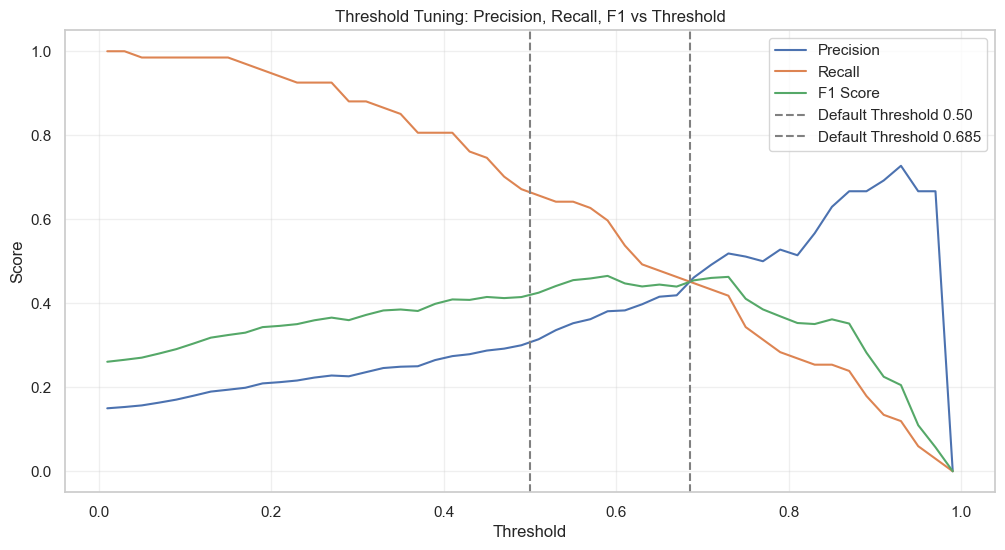

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.01, 0.99, 50)

precision_scores = []
recall_scores = []
f1_scores = []

for t in thresholds:
    y_pred_t = (y_proba_tuned >= t).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_t))
    recall_scores.append(recall_score(y_test, y_pred_t))
    f1_scores.append(f1_score(y_test, y_pred_t))

plt.figure(figsize=(12,6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold 0.50')
plt.axvline(0.685, color='gray', linestyle='--', label='Default Threshold 0.685')


plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning: Precision, Recall, F1 vs Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Summary

The F1 Score is the value that should be taking center stage in this graphic. This score is the best balance between Precision and Recall. The F1 Score reaches it's peak around 0.55-0.60 then falls off as recall dimishes. What this tells us is the default threshold of 0.50 will contain more false positives and by increasing the threshold to .55 or even .6 there will be fewer targeted customers but the remaining customers will have a better chance at saying yes to the year end membership offer. 

### Gains Chart 

The Gains Chart answers:

“If I target the customers the model thinks are most likely to buy, what % of actual buyers will I capture?”

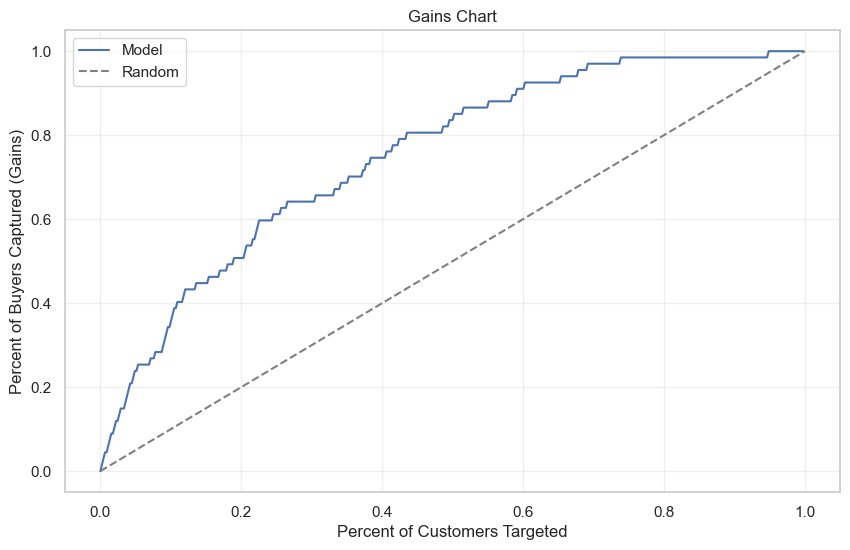

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Build dataframe for gains/lift calculations
df_eval = pd.DataFrame({
    'y_true': y_test.values,
    'y_proba': y_proba_tuned
})

# Sort by predicted probability
df_eval = df_eval.sort_values(by='y_proba', ascending=False).reset_index(drop=True)

# Add cumulative true positives
df_eval['cum_true'] = df_eval['y_true'].cumsum()

# Total number of positives
total_positives = df_eval['y_true'].sum()

# Gains = % of total positives captured at each row
df_eval['gains'] = df_eval['cum_true'] / total_positives

# Plot Gains Curve
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(df_eval))/len(df_eval), df_eval['gains'], label='Model')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random')

plt.xlabel("Percent of Customers Targeted")
plt.ylabel("Percent of Buyers Captured (Gains)")
plt.title("Gains Chart")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Gains Chart Summary

- The top 10% of all customers accounts for roughly 30% of all buyers.
- The top 20% of all customers accounts for roughly 50% of all buyers.
- The top 30% of all customers accounts for roughly 65% of all buyers.

Recommendation:  Target the top 40% of accounts to capture about 75% of all buyers. This is a balanced approach to capture the most membership sales while optimizing the call center staff's resources. 

In [ ]:
git config --global user.email "katie.delvalle@gmail.com"
git config --global user.name "Katie DelValle"